In [1]:
import boto3
from botocore import UNSIGNED
from botocore.client import Config
from tempfile import NamedTemporaryFile
import io
import iris
from metpy.plots import ctables

In [2]:
import matplotlib.pyplot as plt
import iris.quickplot as qplt
import iris.plot as iplt

In [3]:
def list_forecast_hours(run_prefix):
    files = []
    hours = []
    run_hour = run_prefix.split('/')[-2]
    s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    result = s3_client.list_objects_v2(Bucket='noaa-gfs-bdp-pds',
                                       Prefix =f'{run_prefix}atmos/gfs.t{run_hour}z.pgrb2.0p25.f')
    files = result.get('Contents')
    for file_meta in files:
        filename = file_meta['Key']
        if not filename.endswith('.idx'):
            hours.append(int(filename.split('.')[-1].lstrip('f')))
    
    return hours
    

def get_latest_model_run():
    s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    result = s3_client.list_objects_v2(Bucket='noaa-gfs-bdp-pds',
                                    Prefix ='gfs.',
                                    Delimiter='/')
    runs = []
    dates = []
    latest_runs = []
    for item in result.get('CommonPrefixes'):
        model, date = item.get('Prefix').strip('/').split('.')
        dates.append(item.get('Prefix'))
    
    for latest_date in dates[-2:]:
        new_result = s3_client.list_objects_v2(Bucket='noaa-gfs-bdp-pds',
                                    Prefix =f'{latest_date}',
                                    Delimiter='/')
        for item in new_result.get('CommonPrefixes'):
            latest_runs.append(item.get('Prefix'))
    return latest_runs

def get_model_data(param, level, run, hours, merged=True):
    run_hour = run.split('/')[-2]
    s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    
    cubes = []
    for forecast in hours:
        forecast_file = f'{run}atmos/gfs.t{run_hour}z.pgrb2.0p25.f{forecast:03d}'
        data_index = s3_client.get_object(Bucket='noaa-gfs-bdp-pds',
                                          Key=f'{forecast_file}.idx')
        body = data_index["Body"]
        contents = body.read().decode(encoding="utf-8", errors="ignore")
        idx_data = parse_index_file(contents)
        
        # param_to_get = idx_data['2 m above ground']['TMP']
        param_to_get = idx_data[level][param]
        
        print(f'Filename = {forecast_file}, param_to_get = {param_to_get}')
        data_response = s3_client.get_object(Bucket='noaa-gfs-bdp-pds',
                                             Key=forecast_file,
                                             Range=f'bytes={param_to_get["start_byte"]}-{param_to_get["end_byte"]}')
        
        data = data_response["Body"].read()
        dl_name = f'/tmp/{forecast}_{level}_{param}'
        with open(dl_name, 'wb') as f:
            f.write(data)
        cubes.append(iris.load(dl_name)[0])
    
    if len(hours) > 1:
        cubes = iris.cube.CubeList(cubes)
        if merged is True:
            merged_cube = cubes.merge_cube()
            return merged_cube
        else:
            return cubes
        
    else:
        return cubes[0]
        
def parse_index_file(index_data):
    data_dict = {}
    last_level = None
    last_param = None
    for row in index_data.splitlines():    
        num, start_byte, model_run, param, level, fcst, dummy = row.split(':')
        if last_param is not None and last_level is not None:
            data_dict[last_level][last_param]['end_byte'] = int(start_byte) - 1
        if level not in data_dict.keys():
            data_dict[level] = {}
        data_dict[level][param] = {'start_byte': start_byte}
        last_level = level
        last_param = param
    return data_dict


In [4]:
runs = get_latest_model_run()
hours = list_forecast_hours(runs[-1])

In [75]:
run = runs[-1]
level = '2 m above ground'
param = 'TEMP'
forecasts = hours[8:9]

refc_cubes = get_model_data(param, level, run, forecasts)

Filename = gfs.20220713/12/atmos/gfs.t12z.pgrb2.0p25.f008, param_to_get = {'start_byte': '3443696', 'end_byte': 4422315}


/opt/conda/lib/python3.10/site-packages/iris/coords.py:1806: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/iris/coords.py:1806: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


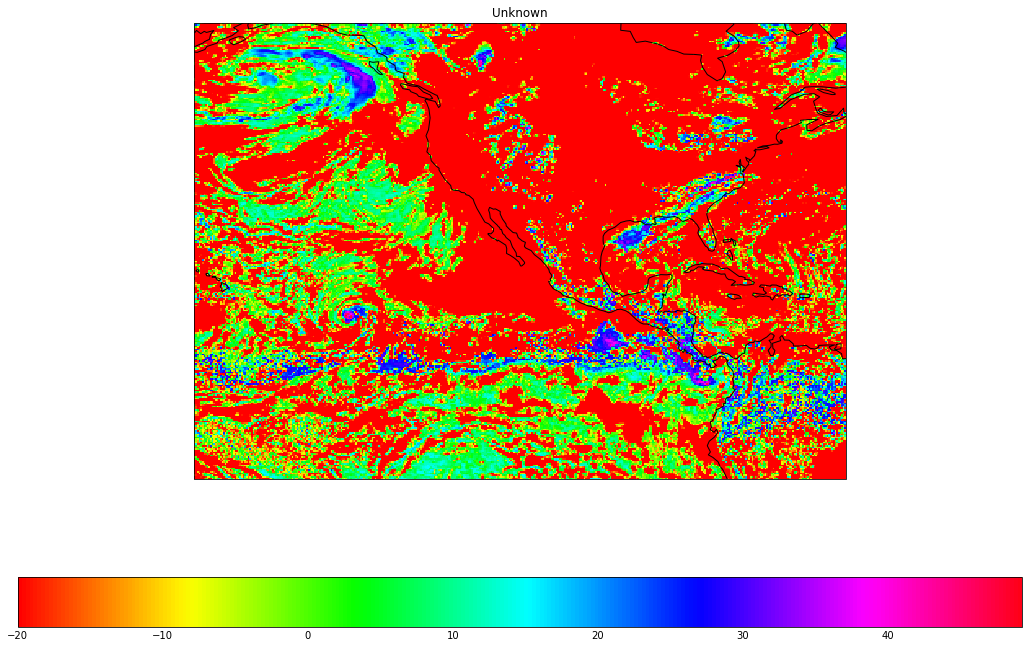

In [84]:

plt.figure(figsize=(18, 12))

qplt.pcolormesh(refc_cubes[120:400,800:1200], cmap="hsv")

# Add coastlines to the map created by contourf.
plt.gca().coastlines()

plt.show()

In [72]:
import numpy as np
refc_cubes.data = np.ma.masked_where(refc_cubes.data < 0, refc_cubes.data)


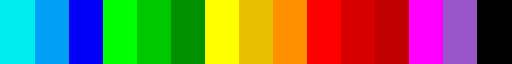

In [69]:
ctables.colortables.get_colortable("NWSReflectivity")

In [15]:
s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
data_index = s3_client.get_object(Bucket='noaa-gfs-bdp-pds',
                                  Key='gfs.20220713/12/atmos/gfs.t12z.pgrb2.0p25.f000.idx')


In [16]:
body = data_index["Body"]
contents = body.read().decode(encoding="utf-8", errors="ignore")
data_dict = {}
last_level = None
last_param = None
for row in contents.splitlines():    
    num, start_byte, model_run, param, level, fcst, dummy = row.split(':')
    if last_param is not None and last_level is not None:
        data_dict[last_level][last_param]['end_byte'] = int(start_byte) - 1
    if level not in data_dict.keys():
        data_dict[level] = {}
    data_dict[level][param] = {'start_byte': start_byte}
    last_level = level
    last_param = param

In [62]:
data_dict

{'mean sea level': {'PRMSL': {'start_byte': '0', 'end_byte': 1008127},
  'MSLET': {'start_byte': '398003449', 'end_byte': 398966195}},
 '1 hybrid level': {'CLWMR': {'start_byte': '1008128', 'end_byte': 1129379},
  'ICMR': {'start_byte': '1129380', 'end_byte': 1316525},
  'RWMR': {'start_byte': '1316526', 'end_byte': 1570117},
  'SNMR': {'start_byte': '1570118', 'end_byte': 1648091},
  'GRLE': {'start_byte': '1648092', 'end_byte': 1690126},
  'REFD': {'start_byte': '1690127', 'end_byte': 2576523}},
 '2 hybrid level': {'REFD': {'start_byte': '2576524', 'end_byte': 3462313}},
 'entire atmosphere': {'REFC': {'start_byte': '3462314', 'end_byte': 4439419},
  'TCDC': {'start_byte': '425690777', 'end_byte': 426534899}},
 'surface': {'VIS': {'start_byte': '4439420', 'end_byte': 5156061},
  'GUST': {'start_byte': '6680818', 'end_byte': 7300082},
  'HINDEX': {'start_byte': '378634147', 'end_byte': 378836315},
  'PRES': {'start_byte': '401143595', 'end_byte': 401979484},
  'HGT': {'start_byte': '4

In [19]:
param_to_get = data_dict['2 m above ground']['TMP']
s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
sfc_temp = s3_client.get_object(Bucket='noaa-gfs-bdp-pds',
                                Key='gfs.20220713/12/atmos/gfs.t12z.pgrb2.0p25.f000',
                                Range=f'bytes={param_to_get["start_byte"]}-{param_to_get["end_byte"]}')

In [20]:
sfc_temp_data = sfc_temp["Body"].read()
temp_file = NamedTemporaryFile(mode='wb')
temp_file.write(sfc_temp_data)
cube = iris.load(temp_file.name)

In [27]:
type(cube)

iris.cube.CubeList

In [25]:
temp_cube = cube[0]

/opt/conda/lib/python3.10/site-packages/iris/coords.py:1806: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/iris/coords.py:1806: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


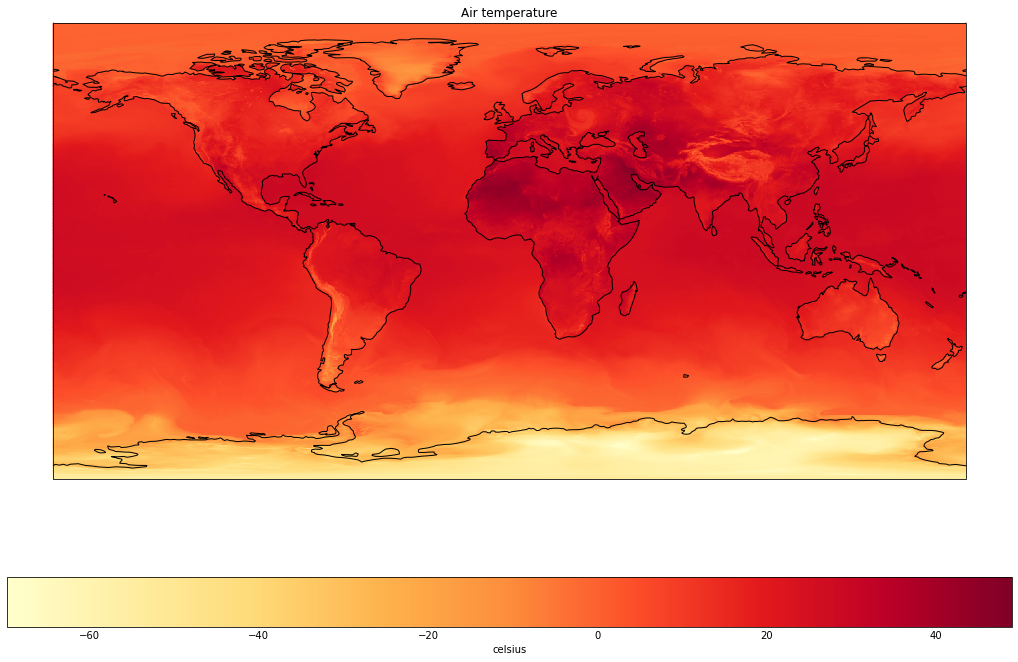

In [30]:
temp_cube.convert_units('celsius')

plt.figure(figsize=(18, 12))

qplt.pcolormesh(temp_cube, cmap='YlOrRd')

# Add coastlines to the map created by contourf.
plt.gca().coastlines()

plt.show()

In [40]:
sample_points = [('latitude', 42), ('longitude', -96), ]
datar = temperature_cubes.interpolate(sample_points, iris.analysis.Linear())

In [45]:
datar.convert_units('fahrenheit')

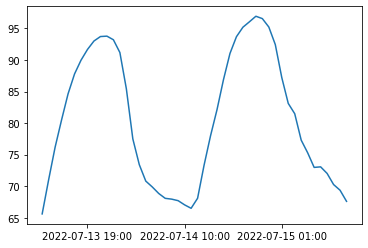

In [46]:
iplt.plot(datar)
plt.show()

In [52]:
plt.figure(figsize=(18, 12))

qplt.pcolormesh(temperature_cubes[6].data[100:300][200:500], cmap='YlOrRd')

# Add coastlines to the map created by contourf.
plt.gca().coastlines()

plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'dim_coords'

<Figure size 1296x864 with 0 Axes>

In [ ]:
response = s3_client.list_objects_v2(Bucket='noaa-gfs-bdp-pds',
                                     Prefix ='gfs.20220711/06/atmos/gfs.t06z.pgrb2')

In [ ]:
mrms = iris.load('MRMS_MergedReflectivityQCComposite.latest.grib2')

In [ ]:
mrms[0]

In [ ]:
metpy_maps = {'Carbone42': [(0.4666666666666667, 0.0196078431372549, 0.6392156862745098), (0.4, 0.2235294117647059, 0.5568627450980392), (0.1607843137254902, 0.054901960784313725, 0.5803921568627451), (0.2235294117647059, 0.054901960784313725, 0.6705882352941176), (0.28627450980392155, 0.054901960784313725, 0.7647058823529411), (0.34901960784313724, 0.13725490196078433, 0.8941176470588236), (0.4117647058823529, 0.37254901960784315, 0.9921568627450981), (0.44313725490196076, 0.5568627450980392, 0.9921568627450981), (0.2784313725490196, 0.5882352941176471, 0.6), (0.1843137254901961, 0.5215686274509804, 0.3686274509803922), (0.00392156862745098, 0.44313725490196076, 0.0), (0.0, 0.49019607843137253, 0.0), (0.0, 0.5372549019607843, 0.0), (0.058823529411764705, 0.5843137254901961, 0.058823529411764705), (0.17254901960784313, 0.6313725490196078, 0.17254901960784313), (0.28627450980392155, 0.6784313725490196, 0.28627450980392155), (0.4, 0.7215686274509804, 0.4), (0.5176470588235295, 0.7686274509803922, 0.5176470588235295), (0.6313725490196078, 0.8156862745098039, 0.6313725490196078), (0.7490196078431373, 0.8627450980392157, 0.7490196078431373), (0.8156862745098039, 0.8901960784313725, 0.8156862745098039), (0.9254901960784314, 0.8901960784313725, 0.6901960784313725), (0.9372549019607843, 0.8588235294117647, 0.34901960784313724), (0.9372549019607843, 0.8117647058823529, 0.0), (0.9372549019607843, 0.7647058823529411, 0.0196078431372549), (0.9372549019607843, 0.7176470588235294, 0.054901960784313725), (0.9254901960784314, 0.6705882352941176, 0.08235294117647059), (0.8705882352941177, 0.6235294117647059, 0.11372549019607843), (0.8156862745098039, 0.5764705882352941, 0.1450980392156863), (0.7568627450980392, 0.5294117647058824, 0.17647058823529413), (0.7019607843137254, 0.4823529411764706, 0.20784313725490197), (0.6470588235294118, 0.43529411764705883, 0.23921568627450981), (0.5882352941176471, 0.38823529411764707, 0.24705882352941178), (0.5333333333333333, 0.3411764705882353, 0.24705882352941178), (0.4823529411764706, 0.3254901960784314, 0.29411764705882354), (0.6274509803921569, 0.30980392156862746, 0.37254901960784315), (0.6235294117647059, 0.0, 0.0), (0.7176470588235294, 0.08235294117647059, 0.1843137254901961), (0.8117647058823529, 0.1450980392156863, 0.27058823529411763), (0.8784313725490196, 0.20784313725490197, 0.35294117647058826), (0.9450980392156862, 0.27058823529411763, 0.35294117647058826), (1.0, 0.011764705882352941, 0.0)], 'Carbone42_r': [(1.0, 0.011764705882352941, 0.0), (0.9450980392156862, 0.27058823529411763, 0.35294117647058826), (0.8784313725490196, 0.20784313725490197, 0.35294117647058826), (0.8117647058823529, 0.1450980392156863, 0.27058823529411763), (0.7176470588235294, 0.08235294117647059, 0.1843137254901961), (0.6235294117647059, 0.0, 0.0), (0.6274509803921569, 0.30980392156862746, 0.37254901960784315), (0.4823529411764706, 0.3254901960784314, 0.29411764705882354), (0.5333333333333333, 0.3411764705882353, 0.24705882352941178), (0.5882352941176471, 0.38823529411764707, 0.24705882352941178), (0.6470588235294118, 0.43529411764705883, 0.23921568627450981), (0.7019607843137254, 0.4823529411764706, 0.20784313725490197), (0.7568627450980392, 0.5294117647058824, 0.17647058823529413), (0.8156862745098039, 0.5764705882352941, 0.1450980392156863), (0.8705882352941177, 0.6235294117647059, 0.11372549019607843), (0.9254901960784314, 0.6705882352941176, 0.08235294117647059), (0.9372549019607843, 0.7176470588235294, 0.054901960784313725), (0.9372549019607843, 0.7647058823529411, 0.0196078431372549), (0.9372549019607843, 0.8117647058823529, 0.0), (0.9372549019607843, 0.8588235294117647, 0.34901960784313724), (0.9254901960784314, 0.8901960784313725, 0.6901960784313725), (0.8156862745098039, 0.8901960784313725, 0.8156862745098039), (0.7490196078431373, 0.8627450980392157, 0.7490196078431373), (0.6313725490196078, 0.8156862745098039, 0.6313725490196078), (0.5176470588235295, 0.7686274509803922, 0.5176470588235295), (0.4, 0.7215686274509804, 0.4), (0.28627450980392155, 0.6784313725490196, 0.28627450980392155), (0.17254901960784313, 0.6313725490196078, 0.17254901960784313), (0.058823529411764705, 0.5843137254901961, 0.058823529411764705), (0.0, 0.5372549019607843, 0.0), (0.0, 0.49019607843137253, 0.0), (0.00392156862745098, 0.44313725490196076, 0.0), (0.1843137254901961, 0.5215686274509804, 0.3686274509803922), (0.2784313725490196, 0.5882352941176471, 0.6), (0.44313725490196076, 0.5568627450980392, 0.9921568627450981), (0.4117647058823529, 0.37254901960784315, 0.9921568627450981), (0.34901960784313724, 0.13725490196078433, 0.8941176470588236), (0.28627450980392155, 0.054901960784313725, 0.7647058823529411), (0.2235294117647059, 0.054901960784313725, 0.6705882352941176), (0.1607843137254902, 0.054901960784313725, 0.5803921568627451), (0.4, 0.2235294117647059, 0.5568627450980392), (0.4666666666666667, 0.0196078431372549, 0.6392156862745098)], 'NWS8bitVel': [(0.333333, 0.019608, 0.6), (0.301961, 0.015686, 0.6), (0.270588, 0.015686, 0.6), (0.239216, 0.011765, 0.6), (0.203922, 0.011765, 0.6), (0.172549, 0.011765, 0.6), (0.141176, 0.007843, 0.6), (0.109804, 0.007843, 0.6), (0.086275, 0.007843, 0.6), (0.086275, 0.047059, 0.611765), (0.090196, 0.090196, 0.627451), (0.094118, 0.133333, 0.639216), (0.098039, 0.172549, 0.654902), (0.101961, 0.215686, 0.666667), (0.105882, 0.258824, 0.682353), (0.109804, 0.298039, 0.694118), (0.113725, 0.341176, 0.709804), (0.117647, 0.384314, 0.721569), (0.121569, 0.423529, 0.737255), (0.12549, 0.466667, 0.752941), (0.129412, 0.509804, 0.764706), (0.133333, 0.54902, 0.780392), (0.137255, 0.592157, 0.792157), (0.141176, 0.635294, 0.807843), (0.145098, 0.67451, 0.819608), (0.14902, 0.717647, 0.835294), (0.152941, 0.760784, 0.847059), (0.156863, 0.8, 0.862745), (0.188235, 0.878431, 0.890196), (0.203922, 0.878431, 0.890196), (0.227451, 0.878431, 0.890196), (0.254902, 0.882353, 0.894118), (0.278431, 0.886275, 0.898039), (0.305882, 0.886275, 0.898039), (0.329412, 0.890196, 0.901961), (0.356863, 0.894118, 0.905882), (0.380392, 0.898039, 0.909804), (0.407843, 0.898039, 0.909804), (0.431373, 0.901961, 0.913725), (0.458824, 0.905882, 0.917647), (0.482353, 0.905882, 0.917647), (0.509804, 0.909804, 0.921569), (0.533333, 0.913725, 0.92549), (0.560784, 0.917647, 0.929412), (0.584314, 0.917647, 0.929412), (0.611765, 0.921569, 0.933333), (0.635294, 0.92549, 0.937255), (0.662745, 0.92549, 0.937255), (0.686275, 0.929412, 0.941176), (0.713725, 0.933333, 0.945098), (0.654902, 0.945098, 0.854902), (0.603922, 0.94902, 0.784314), (0.54902, 0.952941, 0.709804), (0.498039, 0.960784, 0.639216), (0.443137, 0.964706, 0.564706), (0.392157, 0.968627, 0.494118), (0.341176, 0.972549, 0.423529), (0.286275, 0.980392, 0.34902), (0.235294, 0.984314, 0.278431), (0.180392, 0.988235, 0.203922), (0.129412, 0.992157, 0.133333), (0.011765, 0.980392, 0.011765), (0.011765, 0.960784, 0.011765), (0.011765, 0.941176, 0.011765), (0.011765, 0.917647, 0.011765), (0.011765, 0.898039, 0.011765), (0.011765, 0.878431, 0.011765), (0.011765, 0.858824, 0.011765), (0.011765, 0.835294, 0.011765), (0.011765, 0.815686, 0.011765), (0.011765, 0.796078, 0.011765), (0.011765, 0.776471, 0.011765), (0.011765, 0.752941, 0.011765), (0.011765, 0.733333, 0.011765), (0.011765, 0.713725, 0.011765), (0.011765, 0.694118, 0.011765), (0.007843, 0.670588, 0.007843), (0.007843, 0.65098, 0.007843), (0.007843, 0.631373, 0.007843), (0.007843, 0.611765, 0.007843), (0.007843, 0.588235, 0.007843), (0.007843, 0.568627, 0.007843), (0.007843, 0.54902, 0.007843), (0.007843, 0.529412, 0.007843), (0.007843, 0.505882, 0.007843), (0.007843, 0.486275, 0.007843), (0.007843, 0.466667, 0.007843), (0.007843, 0.447059, 0.007843), (0.007843, 0.423529, 0.007843), (0.007843, 0.403922, 0.007843), (0.019608, 0.4, 0.011765), (0.305882, 0.47451, 0.298039), (0.321569, 0.478431, 0.313725), (0.337255, 0.486275, 0.329412), (0.352941, 0.490196, 0.345098), (0.368627, 0.494118, 0.360784), (0.384314, 0.501961, 0.376471), (0.4, 0.505882, 0.392157), (0.415686, 0.509804, 0.407843), (0.431373, 0.517647, 0.423529), (0.447059, 0.521569, 0.439216), (0.541176, 0.462745, 0.462745), (0.541176, 0.447059, 0.505882), (0.541176, 0.423529, 0.478431), (0.537255, 0.4, 0.45098), (0.533333, 0.372549, 0.423529), (0.533333, 0.34902, 0.396078), (0.529412, 0.321569, 0.368627), (0.52549, 0.298039, 0.337255), (0.521569, 0.270588, 0.309804), (0.521569, 0.247059, 0.282353), (0.517647, 0.219608, 0.254902), (0.431373, 0.0, 0.0), (0.45098, 0.0, 0.0), (0.47451, 0.0, 0.0), (0.494118, 0.0, 0.0), (0.517647, 0.0, 0.003922), (0.537255, 0.0, 0.003922), (0.560784, 0.0, 0.003922), (0.584314, 0.0, 0.007843), (0.603922, 0.0, 0.007843), (0.627451, 0.0, 0.007843), (0.647059, 0.0, 0.011765), (0.670588, 0.0, 0.011765), (0.690196, 0.0, 0.011765), (0.713725, 0.0, 0.015686), (0.737255, 0.0, 0.015686), (0.756863, 0.0, 0.015686), (0.780392, 0.0, 0.015686), (0.8, 0.0, 0.019608), (0.823529, 0.0, 0.019608), (0.843137, 0.0, 0.019608), (0.866667, 0.0, 0.023529), (0.890196, 0.0, 0.023529), (0.909804, 0.0, 0.023529), (0.933333, 0.0, 0.027451), (0.952941, 0.0, 0.027451), (0.980392, 0.215686, 0.317647), (0.980392, 0.235294, 0.34902), (0.980392, 0.254902, 0.380392), (0.980392, 0.278431, 0.411765), (0.984314, 0.298039, 0.443137), (0.984314, 0.321569, 0.478431), (0.984314, 0.341176, 0.509804), (0.988235, 0.364706, 0.541176), (0.988235, 0.384314, 0.572549), (0.988235, 0.407843, 0.607843), (0.988235, 0.427451, 0.639216), (0.992157, 0.45098, 0.670588), (0.992157, 0.470588, 0.701961), (0.992157, 0.494118, 0.737255), (0.996078, 0.513725, 0.768627), (0.996078, 0.537255, 0.8), (1.0, 0.54902, 0.835294), (1.0, 0.584314, 0.815686), (1.0, 0.623529, 0.796078), (1.0, 0.658824, 0.776471), (1.0, 0.698039, 0.756863), (1.0, 0.733333, 0.737255), (1.0, 0.772549, 0.717647), (1.0, 0.807843, 0.698039), (1.0, 0.847059, 0.678431), (1.0, 0.882353, 0.658824), (1.0, 0.909804, 0.639216), (1.0, 0.894118, 0.623529), (1.0, 0.878431, 0.607843), (1.0, 0.858824, 0.592157), (1.0, 0.843137, 0.576471), (1.0, 0.827451, 0.556863), (1.0, 0.807843, 0.541176), (1.0, 0.792157, 0.52549), (1.0, 0.772549, 0.509804), (1.0, 0.756863, 0.490196), (1.0, 0.741176, 0.47451), (1.0, 0.721569, 0.458824), (1.0, 0.705882, 0.443137), (1.0, 0.690196, 0.423529), (1.0, 0.670588, 0.407843), (1.0, 0.654902, 0.392157), (1.0, 0.635294, 0.376471), (1.0, 0.619608, 0.356863), (1.0, 0.603922, 0.341176), (1.0, 0.584314, 0.32549), (1.0, 0.541176, 0.309804), (0.988235, 0.529412, 0.305882), (0.972549, 0.517647, 0.298039), (0.960784, 0.505882, 0.290196), (0.945098, 0.494118, 0.282353), (0.933333, 0.482353, 0.278431), (0.917647, 0.470588, 0.270588), (0.905882, 0.458824, 0.262745), (0.890196, 0.447059, 0.254902), (0.878431, 0.435294, 0.247059), (0.862745, 0.423529, 0.243137), (0.847059, 0.407843, 0.235294), (0.835294, 0.396078, 0.227451), (0.819608, 0.384314, 0.219608), (0.807843, 0.372549, 0.211765), (0.792157, 0.360784, 0.207843), (0.780392, 0.34902, 0.2)], 'NWS8bitVel_r': [(0.780392, 0.34902, 0.2), (0.792157, 0.360784, 0.207843), (0.807843, 0.372549, 0.211765), (0.819608, 0.384314, 0.219608), (0.835294, 0.396078, 0.227451), (0.847059, 0.407843, 0.235294), (0.862745, 0.423529, 0.243137), (0.878431, 0.435294, 0.247059), (0.890196, 0.447059, 0.254902), (0.905882, 0.458824, 0.262745), (0.917647, 0.470588, 0.270588), (0.933333, 0.482353, 0.278431), (0.945098, 0.494118, 0.282353), (0.960784, 0.505882, 0.290196), (0.972549, 0.517647, 0.298039), (0.988235, 0.529412, 0.305882), (1.0, 0.541176, 0.309804), (1.0, 0.584314, 0.32549), (1.0, 0.603922, 0.341176), (1.0, 0.619608, 0.356863), (1.0, 0.635294, 0.376471), (1.0, 0.654902, 0.392157), (1.0, 0.670588, 0.407843), (1.0, 0.690196, 0.423529), (1.0, 0.705882, 0.443137), (1.0, 0.721569, 0.458824), (1.0, 0.741176, 0.47451), (1.0, 0.756863, 0.490196), (1.0, 0.772549, 0.509804), (1.0, 0.792157, 0.52549), (1.0, 0.807843, 0.541176), (1.0, 0.827451, 0.556863), (1.0, 0.843137, 0.576471), (1.0, 0.858824, 0.592157), (1.0, 0.878431, 0.607843), (1.0, 0.894118, 0.623529), (1.0, 0.909804, 0.639216), (1.0, 0.882353, 0.658824), (1.0, 0.847059, 0.678431), (1.0, 0.807843, 0.698039), (1.0, 0.772549, 0.717647), (1.0, 0.733333, 0.737255), (1.0, 0.698039, 0.756863), (1.0, 0.658824, 0.776471), (1.0, 0.623529, 0.796078), (1.0, 0.584314, 0.815686), (1.0, 0.54902, 0.835294), (0.996078, 0.537255, 0.8), (0.996078, 0.513725, 0.768627), (0.992157, 0.494118, 0.737255), (0.992157, 0.470588, 0.701961), (0.992157, 0.45098, 0.670588), (0.988235, 0.427451, 0.639216), (0.988235, 0.407843, 0.607843), (0.988235, 0.384314, 0.572549), (0.988235, 0.364706, 0.541176), (0.984314, 0.341176, 0.509804), (0.984314, 0.321569, 0.478431), (0.984314, 0.298039, 0.443137), (0.980392, 0.278431, 0.411765), (0.980392, 0.254902, 0.380392), (0.980392, 0.235294, 0.34902), (0.980392, 0.215686, 0.317647), (0.952941, 0.0, 0.027451), (0.933333, 0.0, 0.027451), (0.909804, 0.0, 0.023529), (0.890196, 0.0, 0.023529), (0.866667, 0.0, 0.023529), (0.843137, 0.0, 0.019608), (0.823529, 0.0, 0.019608), (0.8, 0.0, 0.019608), (0.780392, 0.0, 0.015686), (0.756863, 0.0, 0.015686), (0.737255, 0.0, 0.015686), (0.713725, 0.0, 0.015686), (0.690196, 0.0, 0.011765), (0.670588, 0.0, 0.011765), (0.647059, 0.0, 0.011765), (0.627451, 0.0, 0.007843), (0.603922, 0.0, 0.007843), (0.584314, 0.0, 0.007843), (0.560784, 0.0, 0.003922), (0.537255, 0.0, 0.003922), (0.517647, 0.0, 0.003922), (0.494118, 0.0, 0.0), (0.47451, 0.0, 0.0), (0.45098, 0.0, 0.0), (0.431373, 0.0, 0.0), (0.517647, 0.219608, 0.254902), (0.521569, 0.247059, 0.282353), (0.521569, 0.270588, 0.309804), (0.52549, 0.298039, 0.337255), (0.529412, 0.321569, 0.368627), (0.533333, 0.34902, 0.396078), (0.533333, 0.372549, 0.423529), (0.537255, 0.4, 0.45098), (0.541176, 0.423529, 0.478431), (0.541176, 0.447059, 0.505882), (0.541176, 0.462745, 0.462745), (0.447059, 0.521569, 0.439216), (0.431373, 0.517647, 0.423529), (0.415686, 0.509804, 0.407843), (0.4, 0.505882, 0.392157), (0.384314, 0.501961, 0.376471), (0.368627, 0.494118, 0.360784), (0.352941, 0.490196, 0.345098), (0.337255, 0.486275, 0.329412), (0.321569, 0.478431, 0.313725), (0.305882, 0.47451, 0.298039), (0.019608, 0.4, 0.011765), (0.007843, 0.403922, 0.007843), (0.007843, 0.423529, 0.007843), (0.007843, 0.447059, 0.007843), (0.007843, 0.466667, 0.007843), (0.007843, 0.486275, 0.007843), (0.007843, 0.505882, 0.007843), (0.007843, 0.529412, 0.007843), (0.007843, 0.54902, 0.007843), (0.007843, 0.568627, 0.007843), (0.007843, 0.588235, 0.007843), (0.007843, 0.611765, 0.007843), (0.007843, 0.631373, 0.007843), (0.007843, 0.65098, 0.007843), (0.007843, 0.670588, 0.007843), (0.011765, 0.694118, 0.011765), (0.011765, 0.713725, 0.011765), (0.011765, 0.733333, 0.011765), (0.011765, 0.752941, 0.011765), (0.011765, 0.776471, 0.011765), (0.011765, 0.796078, 0.011765), (0.011765, 0.815686, 0.011765), (0.011765, 0.835294, 0.011765), (0.011765, 0.858824, 0.011765), (0.011765, 0.878431, 0.011765), (0.011765, 0.898039, 0.011765), (0.011765, 0.917647, 0.011765), (0.011765, 0.941176, 0.011765), (0.011765, 0.960784, 0.011765), (0.011765, 0.980392, 0.011765), (0.129412, 0.992157, 0.133333), (0.180392, 0.988235, 0.203922), (0.235294, 0.984314, 0.278431), (0.286275, 0.980392, 0.34902), (0.341176, 0.972549, 0.423529), (0.392157, 0.968627, 0.494118), (0.443137, 0.964706, 0.564706), (0.498039, 0.960784, 0.639216), (0.54902, 0.952941, 0.709804), (0.603922, 0.94902, 0.784314), (0.654902, 0.945098, 0.854902), (0.713725, 0.933333, 0.945098), (0.686275, 0.929412, 0.941176), (0.662745, 0.92549, 0.937255), (0.635294, 0.92549, 0.937255), (0.611765, 0.921569, 0.933333), (0.584314, 0.917647, 0.929412), (0.560784, 0.917647, 0.929412), (0.533333, 0.913725, 0.92549), (0.509804, 0.909804, 0.921569), (0.482353, 0.905882, 0.917647), (0.458824, 0.905882, 0.917647), (0.431373, 0.901961, 0.913725), (0.407843, 0.898039, 0.909804), (0.380392, 0.898039, 0.909804), (0.356863, 0.894118, 0.905882), (0.329412, 0.890196, 0.901961), (0.305882, 0.886275, 0.898039), (0.278431, 0.886275, 0.898039), (0.254902, 0.882353, 0.894118), (0.227451, 0.878431, 0.890196), (0.203922, 0.878431, 0.890196), (0.188235, 0.878431, 0.890196), (0.156863, 0.8, 0.862745), (0.152941, 0.760784, 0.847059), (0.14902, 0.717647, 0.835294), (0.145098, 0.67451, 0.819608), (0.141176, 0.635294, 0.807843), (0.137255, 0.592157, 0.792157), (0.133333, 0.54902, 0.780392), (0.129412, 0.509804, 0.764706), (0.12549, 0.466667, 0.752941), (0.121569, 0.423529, 0.737255), (0.117647, 0.384314, 0.721569), (0.113725, 0.341176, 0.709804), (0.109804, 0.298039, 0.694118), (0.105882, 0.258824, 0.682353), (0.101961, 0.215686, 0.666667), (0.098039, 0.172549, 0.654902), (0.094118, 0.133333, 0.639216), (0.090196, 0.090196, 0.627451), (0.086275, 0.047059, 0.611765), (0.086275, 0.007843, 0.6), (0.109804, 0.007843, 0.6), (0.141176, 0.007843, 0.6), (0.172549, 0.011765, 0.6), (0.203922, 0.011765, 0.6), (0.239216, 0.011765, 0.6), (0.270588, 0.015686, 0.6), (0.301961, 0.015686, 0.6), (0.333333, 0.019608, 0.6)], 'NWSReflectivity': [(0.0, 0.9254901960784314, 0.9254901960784314), (0.00392156862745098, 0.6274509803921569, 0.9647058823529412), (0.0, 0.0, 0.9647058823529412), (0.0, 1.0, 0.0), (0.0, 0.7843137254901961, 0.0), (0.0, 0.5647058823529412, 0.0), (1.0, 1.0, 0.0), (0.9058823529411765, 0.7529411764705882, 0.0), (1.0, 0.5647058823529412, 0.0), (1.0, 0.0, 0.0), (0.8392156862745098, 0.0, 0.0), (0.7529411764705882, 0.0, 0.0), (1.0, 0.0, 1.0), (0.6, 0.3333333333333333, 0.788235294117647), (0.0, 0.0, 0.0)], 'NWSReflectivityExpanded': [(0.39215686274509803, 0.39215686274509803, 0.39215686274509803), (0.8, 1.0, 1.0), (0.8, 0.6, 0.8), (0.6, 0.4, 0.6), (0.4, 0.2, 0.4), (0.8, 0.8, 0.6), (0.6, 0.6, 0.4), (0.39215686274509803, 0.39215686274509803, 0.39215686274509803), (0.01568627450980392, 0.9137254901960784, 0.9058823529411765), (0.00392156862745098, 0.6235294117647059, 0.9568627450980393), (0.011764705882352941, 0.0, 0.9568627450980393), (0.00784313725490196, 0.9921568627450981, 0.00784313725490196), (0.00392156862745098, 0.7725490196078432, 0.00392156862745098), (0.0, 0.5568627450980392, 0.0), (0.9921568627450981, 0.9725490196078431, 0.00784313725490196), (0.8980392156862745, 0.7372549019607844, 0.0), (0.9921568627450981, 0.5843137254901961, 0.0), (0.9921568627450981, 0.0, 0.0), (0.8313725490196079, 0.0, 0.0), (0.7372549019607844, 0.0, 0.0), (0.9725490196078431, 0.0, 0.9921568627450981), (0.596078431372549, 0.32941176470588235, 0.7764705882352941), (0.9921568627450981, 0.9921568627450981, 0.9921568627450981)], 'NWSReflectivityExpanded_r': [(0.9921568627450981, 0.9921568627450981, 0.9921568627450981), (0.596078431372549, 0.32941176470588235, 0.7764705882352941), (0.9725490196078431, 0.0, 0.9921568627450981), (0.7372549019607844, 0.0, 0.0), (0.8313725490196079, 0.0, 0.0), (0.9921568627450981, 0.0, 0.0), (0.9921568627450981, 0.5843137254901961, 0.0), (0.8980392156862745, 0.7372549019607844, 0.0), (0.9921568627450981, 0.9725490196078431, 0.00784313725490196), (0.0, 0.5568627450980392, 0.0), (0.00392156862745098, 0.7725490196078432, 0.00392156862745098), (0.00784313725490196, 0.9921568627450981, 0.00784313725490196), (0.011764705882352941, 0.0, 0.9568627450980393), (0.00392156862745098, 0.6235294117647059, 0.9568627450980393), (0.01568627450980392, 0.9137254901960784, 0.9058823529411765), (0.39215686274509803, 0.39215686274509803, 0.39215686274509803), (0.6, 0.6, 0.4), (0.8, 0.8, 0.6), (0.4, 0.2, 0.4), (0.6, 0.4, 0.6), (0.8, 0.6, 0.8), (0.8, 1.0, 1.0), (0.39215686274509803, 0.39215686274509803, 0.39215686274509803)], 'NWSReflectivity_r': [(0.0, 0.0, 0.0), (0.6, 0.3333333333333333, 0.788235294117647), (1.0, 0.0, 1.0), (0.7529411764705882, 0.0, 0.0), (0.8392156862745098, 0.0, 0.0), (1.0, 0.0, 0.0), (1.0, 0.5647058823529412, 0.0), (0.9058823529411765, 0.7529411764705882, 0.0), (1.0, 1.0, 0.0), (0.0, 0.5647058823529412, 0.0), (0.0, 0.7843137254901961, 0.0), (0.0, 1.0, 0.0), (0.0, 0.0, 0.9647058823529412), (0.00392156862745098, 0.6274509803921569, 0.9647058823529412), (0.0, 0.9254901960784314, 0.9254901960784314)], 'NWSSpectrumWidth': [(0.5647058823529412, 0.0, 0.6235294117647059), (0.4627450980392157, 0.4627450980392157, 0.4627450980392157), (0.611764705882353, 0.611764705882353, 0.611764705882353), (0.0, 0.7333333333333333, 0.0), (1.0, 0.0, 0.0), (0.8156862745098039, 0.4392156862745098, 0.0), (1.0, 1.0, 0.0)], 'NWSSpectrumWidth_r': [(1.0, 1.0, 0.0), (0.8156862745098039, 0.4392156862745098, 0.0), (1.0, 0.0, 0.0), (0.0, 0.7333333333333333, 0.0), (0.611764705882353, 0.611764705882353, 0.611764705882353), (0.4627450980392157, 0.4627450980392157, 0.4627450980392157), (0.5647058823529412, 0.0, 0.6235294117647059)], 'NWSStormClearReflectivity': [(0.588235, 0.568627, 0.32549), (0.596078, 0.580392, 0.341176), (0.615686, 0.603922, 0.376471), (0.627451, 0.615686, 0.392157), (0.639216, 0.627451, 0.407843), (0.658824, 0.65098, 0.443137), (0.666667, 0.662745, 0.462745), (0.678431, 0.67451, 0.478431), (0.698039, 0.698039, 0.513725), (0.709804, 0.709804, 0.529412), (0.717647, 0.721569, 0.54902), (0.741176, 0.745098, 0.580392), (0.74902, 0.756863, 0.6), (0.760784, 0.768627, 0.615686), (0.760784, 0.768627, 0.615686), (0.780392, 0.792157, 0.65098), (0.792157, 0.803922, 0.666667), (0.8, 0.815686, 0.686275), (0.811765, 0.823529, 0.705882), (0.8, 0.811765, 0.705882), (0.788235, 0.8, 0.705882), (0.776471, 0.788235, 0.705882), (0.752941, 0.768627, 0.705882), (0.752941, 0.768627, 0.705882), (0.741176, 0.756863, 0.705882), (0.72549, 0.745098, 0.705882), (0.713725, 0.733333, 0.705882), (0.690196, 0.713725, 0.705882), (0.678431, 0.701961, 0.705882), (0.666667, 0.690196, 0.705882), (0.654902, 0.682353, 0.705882), (0.643137, 0.670588, 0.705882), (0.627451, 0.658824, 0.705882), (0.615686, 0.647059, 0.705882), (0.603922, 0.635294, 0.705882), (0.592157, 0.627451, 0.705882), (0.580392, 0.615686, 0.705882), (0.568627, 0.603922, 0.705882), (0.580392, 0.607843, 0.709804), (0.54902, 0.584314, 0.701961), (0.533333, 0.572549, 0.698039), (0.517647, 0.560784, 0.694118), (0.501961, 0.54902, 0.690196), (0.486275, 0.537255, 0.686275), (0.470588, 0.52549, 0.682353), (0.454902, 0.513725, 0.67451), (0.439216, 0.501961, 0.670588), (0.423529, 0.490196, 0.666667), (0.388235, 0.462745, 0.658824), (0.372549, 0.45098, 0.654902), (0.372549, 0.45098, 0.654902), (0.356863, 0.439216, 0.65098), (0.341176, 0.427451, 0.643137), (0.32549, 0.415686, 0.639216), (0.309804, 0.403922, 0.635294), (0.294118, 0.392157, 0.631373), (0.278431, 0.380392, 0.627451), (0.262745, 0.368627, 0.623529), (0.262745, 0.380392, 0.635294), (0.270588, 0.407843, 0.65098), (0.282353, 0.435294, 0.666667), (0.290196, 0.462745, 0.682353), (0.301961, 0.490196, 0.698039), (0.309804, 0.517647, 0.713725), (0.317647, 0.545098, 0.733333), (0.329412, 0.572549, 0.74902), (0.337255, 0.6, 0.764706), (0.34902, 0.623529, 0.780392), (0.356863, 0.65098, 0.796078), (0.368627, 0.678431, 0.811765), (0.376471, 0.705882, 0.831373), (0.384314, 0.733333, 0.847059), (0.396078, 0.760784, 0.862745), (0.403922, 0.788235, 0.878431), (0.415686, 0.815686, 0.894118), (0.435294, 0.839216, 0.909804), (0.407843, 0.839216, 0.843137), (0.380392, 0.839216, 0.772549), (0.34902, 0.839216, 0.701961), (0.321569, 0.839216, 0.635294), (0.294118, 0.839216, 0.564706), (0.262745, 0.839216, 0.494118), (0.235294, 0.839216, 0.427451), (0.207843, 0.839216, 0.356863), (0.066667, 0.835294, 0.094118), (0.066667, 0.819608, 0.090196), (0.062745, 0.803922, 0.090196), (0.062745, 0.784314, 0.086275), (0.062745, 0.768627, 0.086275), (0.058824, 0.752941, 0.082353), (0.058824, 0.737255, 0.082353), (0.058824, 0.717647, 0.078431), (0.054902, 0.701961, 0.078431), (0.054902, 0.686275, 0.07451), (0.054902, 0.670588, 0.07451), (0.05098, 0.65098, 0.070588), (0.05098, 0.635294, 0.070588), (0.05098, 0.619608, 0.066667), (0.047059, 0.6, 0.066667), (0.047059, 0.584314, 0.062745), (0.047059, 0.568627, 0.062745), (0.043137, 0.552941, 0.058824), (0.043137, 0.533333, 0.058824), (0.043137, 0.517647, 0.054902), (0.039216, 0.501961, 0.054902), (0.039216, 0.486275, 0.05098), (0.039216, 0.466667, 0.05098), (0.035294, 0.45098, 0.047059), (0.035294, 0.435294, 0.047059), (0.035294, 0.419608, 0.043137), (0.031373, 0.4, 0.043137), (0.031373, 0.384314, 0.039216), (0.035294, 0.368627, 0.035294), (0.113725, 0.407843, 0.035294), (0.196078, 0.45098, 0.031373), (0.27451, 0.490196, 0.031373), (0.356863, 0.533333, 0.027451), (0.435294, 0.572549, 0.027451), (0.517647, 0.615686, 0.023529), (0.596078, 0.658824, 0.023529), (0.678431, 0.698039, 0.019608), (0.756863, 0.741176, 0.019608), (0.839216, 0.780392, 0.015686), (0.917647, 0.823529, 0.015686), (1.0, 0.886275, 0.0), (1.0, 0.847059, 0.0), (1.0, 0.827451, 0.0), (1.0, 0.788235, 0.0), (1.0, 0.768627, 0.0), (1.0, 0.733333, 0.0), (1.0, 0.713725, 0.0), (1.0, 0.693725, 0.0), (1.0, 0.67451, 0.0), (1.0, 0.654902, 0.0), (1.0, 0.619608, 0.0), (1.0, 0.6, 0.0), (1.0, 0.580392, 0.0), (1.0, 0.541176, 0.0), (1.0, 0.521569, 0.0), (1.0, 0.501569, 0.0), (1.0, 0.0, 0.0), (0.972549, 0.0, 0.0), (0.945098, 0.0, 0.0), (0.917647, 0.0, 0.0), (0.890196, 0.0, 0.0), (0.862745, 0.0, 0.0), (0.835294, 0.0, 0.0), (0.803922, 0.0, 0.0), (0.776471, 0.0, 0.0), (0.74902, 0.0, 0.0), (0.721569, 0.0, 0.0), (0.694118, 0.0, 0.0), (0.666667, 0.0, 0.0), (0.639216, 0.0, 0.0), (0.607843, 0.0, 0.0), (0.580392, 0.0, 0.0), (0.552941, 0.0, 0.0), (0.52549, 0.0, 0.0), (0.498039, 0.0, 0.0), (0.470588, 0.0, 0.0), (0.443137, 0.0, 0.0), (1.0, 1.0, 1.0), (1.0, 0.960784, 1.0), (1.0, 0.917647, 1.0), (1.0, 0.87451, 1.0), (1.0, 0.831373, 1.0), (1.0, 0.788235, 1.0), (1.0, 0.745098, 1.0), (1.0, 0.701961, 1.0), (1.0, 0.658824, 1.0), (1.0, 0.615686, 1.0), (1.0, 0.572549, 1.0), (1.0, 0.458824, 1.0), (0.988235, 0.419608, 0.992157), (0.976471, 0.376471, 0.980392), (0.964706, 0.337255, 0.968627), (0.952941, 0.294118, 0.956863), (0.941176, 0.25098, 0.945098), (0.929412, 0.211765, 0.937255), (0.917647, 0.168627, 0.92549), (0.905882, 0.12549, 0.913725), (0.894118, 0.086275, 0.901961), (0.882353, 0.043137, 0.890196), (0.698039, 0.0, 1.0), (0.67451, 0.0, 0.988235), (0.643137, 0.0, 0.968627), (0.607843, 0.0, 0.956863), (0.576471, 0.0, 0.937255), (0.533333, 0.0, 0.917647), (0.513725, 0.0, 0.909804), (0.47451, 0.0, 0.886275), (0.447059, 0.0, 0.866667), (0.411765, 0.0, 0.858824), (0.388235, 0.0, 0.839216)], 'NWSStormClearReflectivity_r': [(0.388235, 0.0, 0.839216), (0.411765, 0.0, 0.858824), (0.447059, 0.0, 0.866667), (0.47451, 0.0, 0.886275), (0.513725, 0.0, 0.909804), (0.533333, 0.0, 0.917647), (0.576471, 0.0, 0.937255), (0.607843, 0.0, 0.956863), (0.643137, 0.0, 0.968627), (0.67451, 0.0, 0.988235), (0.698039, 0.0, 1.0), (0.882353, 0.043137, 0.890196), (0.894118, 0.086275, 0.901961), (0.905882, 0.12549, 0.913725), (0.917647, 0.168627, 0.92549), (0.929412, 0.211765, 0.937255), (0.941176, 0.25098, 0.945098), (0.952941, 0.294118, 0.956863), (0.964706, 0.337255, 0.968627), (0.976471, 0.376471, 0.980392), (0.988235, 0.419608, 0.992157), (1.0, 0.458824, 1.0), (1.0, 0.572549, 1.0), (1.0, 0.615686, 1.0), (1.0, 0.658824, 1.0), (1.0, 0.701961, 1.0), (1.0, 0.745098, 1.0), (1.0, 0.788235, 1.0), (1.0, 0.831373, 1.0), (1.0, 0.87451, 1.0), (1.0, 0.917647, 1.0), (1.0, 0.960784, 1.0), (1.0, 1.0, 1.0), (0.443137, 0.0, 0.0), (0.470588, 0.0, 0.0), (0.498039, 0.0, 0.0), (0.52549, 0.0, 0.0), (0.552941, 0.0, 0.0), (0.580392, 0.0, 0.0), (0.607843, 0.0, 0.0), (0.639216, 0.0, 0.0), (0.666667, 0.0, 0.0), (0.694118, 0.0, 0.0), (0.721569, 0.0, 0.0), (0.74902, 0.0, 0.0), (0.776471, 0.0, 0.0), (0.803922, 0.0, 0.0), (0.835294, 0.0, 0.0), (0.862745, 0.0, 0.0), (0.890196, 0.0, 0.0), (0.917647, 0.0, 0.0), (0.945098, 0.0, 0.0), (0.972549, 0.0, 0.0), (1.0, 0.0, 0.0), (1.0, 0.501569, 0.0), (1.0, 0.521569, 0.0), (1.0, 0.541176, 0.0), (1.0, 0.580392, 0.0), (1.0, 0.6, 0.0), (1.0, 0.619608, 0.0), (1.0, 0.654902, 0.0), (1.0, 0.67451, 0.0), (1.0, 0.693725, 0.0), (1.0, 0.713725, 0.0), (1.0, 0.733333, 0.0), (1.0, 0.768627, 0.0), (1.0, 0.788235, 0.0), (1.0, 0.827451, 0.0), (1.0, 0.847059, 0.0), (1.0, 0.886275, 0.0), (0.917647, 0.823529, 0.015686), (0.839216, 0.780392, 0.015686), (0.756863, 0.741176, 0.019608), (0.678431, 0.698039, 0.019608), (0.596078, 0.658824, 0.023529), (0.517647, 0.615686, 0.023529), (0.435294, 0.572549, 0.027451), (0.356863, 0.533333, 0.027451), (0.27451, 0.490196, 0.031373), (0.196078, 0.45098, 0.031373), (0.113725, 0.407843, 0.035294), (0.035294, 0.368627, 0.035294), (0.031373, 0.384314, 0.039216), (0.031373, 0.4, 0.043137), (0.035294, 0.419608, 0.043137), (0.035294, 0.435294, 0.047059), (0.035294, 0.45098, 0.047059), (0.039216, 0.466667, 0.05098), (0.039216, 0.486275, 0.05098), (0.039216, 0.501961, 0.054902), (0.043137, 0.517647, 0.054902), (0.043137, 0.533333, 0.058824), (0.043137, 0.552941, 0.058824), (0.047059, 0.568627, 0.062745), (0.047059, 0.584314, 0.062745), (0.047059, 0.6, 0.066667), (0.05098, 0.619608, 0.066667), (0.05098, 0.635294, 0.070588), (0.05098, 0.65098, 0.070588), (0.054902, 0.670588, 0.07451), (0.054902, 0.686275, 0.07451), (0.054902, 0.701961, 0.078431), (0.058824, 0.717647, 0.078431), (0.058824, 0.737255, 0.082353), (0.058824, 0.752941, 0.082353), (0.062745, 0.768627, 0.086275), (0.062745, 0.784314, 0.086275), (0.062745, 0.803922, 0.090196), (0.066667, 0.819608, 0.090196), (0.066667, 0.835294, 0.094118), (0.207843, 0.839216, 0.356863), (0.235294, 0.839216, 0.427451), (0.262745, 0.839216, 0.494118), (0.294118, 0.839216, 0.564706), (0.321569, 0.839216, 0.635294), (0.34902, 0.839216, 0.701961), (0.380392, 0.839216, 0.772549), (0.407843, 0.839216, 0.843137), (0.435294, 0.839216, 0.909804), (0.415686, 0.815686, 0.894118), (0.403922, 0.788235, 0.878431), (0.396078, 0.760784, 0.862745), (0.384314, 0.733333, 0.847059), (0.376471, 0.705882, 0.831373), (0.368627, 0.678431, 0.811765), (0.356863, 0.65098, 0.796078), (0.34902, 0.623529, 0.780392), (0.337255, 0.6, 0.764706), (0.329412, 0.572549, 0.74902), (0.317647, 0.545098, 0.733333), (0.309804, 0.517647, 0.713725), (0.301961, 0.490196, 0.698039), (0.290196, 0.462745, 0.682353), (0.282353, 0.435294, 0.666667), (0.270588, 0.407843, 0.65098), (0.262745, 0.380392, 0.635294), (0.262745, 0.368627, 0.623529), (0.278431, 0.380392, 0.627451), (0.294118, 0.392157, 0.631373), (0.309804, 0.403922, 0.635294), (0.32549, 0.415686, 0.639216), (0.341176, 0.427451, 0.643137), (0.356863, 0.439216, 0.65098), (0.372549, 0.45098, 0.654902), (0.372549, 0.45098, 0.654902), (0.388235, 0.462745, 0.658824), (0.423529, 0.490196, 0.666667), (0.439216, 0.501961, 0.670588), (0.454902, 0.513725, 0.67451), (0.470588, 0.52549, 0.682353), (0.486275, 0.537255, 0.686275), (0.501961, 0.54902, 0.690196), (0.517647, 0.560784, 0.694118), (0.533333, 0.572549, 0.698039), (0.54902, 0.584314, 0.701961), (0.580392, 0.607843, 0.709804), (0.568627, 0.603922, 0.705882), (0.580392, 0.615686, 0.705882), (0.592157, 0.627451, 0.705882), (0.603922, 0.635294, 0.705882), (0.615686, 0.647059, 0.705882), (0.627451, 0.658824, 0.705882), (0.643137, 0.670588, 0.705882), (0.654902, 0.682353, 0.705882), (0.666667, 0.690196, 0.705882), (0.678431, 0.701961, 0.705882), (0.690196, 0.713725, 0.705882), (0.713725, 0.733333, 0.705882), (0.72549, 0.745098, 0.705882), (0.741176, 0.756863, 0.705882), (0.752941, 0.768627, 0.705882), (0.752941, 0.768627, 0.705882), (0.776471, 0.788235, 0.705882), (0.788235, 0.8, 0.705882), (0.8, 0.811765, 0.705882), (0.811765, 0.823529, 0.705882), (0.8, 0.815686, 0.686275), (0.792157, 0.803922, 0.666667), (0.780392, 0.792157, 0.65098), (0.760784, 0.768627, 0.615686), (0.760784, 0.768627, 0.615686), (0.74902, 0.756863, 0.6), (0.741176, 0.745098, 0.580392), (0.717647, 0.721569, 0.54902), (0.709804, 0.709804, 0.529412), (0.698039, 0.698039, 0.513725), (0.678431, 0.67451, 0.478431), (0.666667, 0.662745, 0.462745), (0.658824, 0.65098, 0.443137), (0.639216, 0.627451, 0.407843), (0.627451, 0.615686, 0.392157), (0.615686, 0.603922, 0.376471), (0.596078, 0.580392, 0.341176), (0.588235, 0.568627, 0.32549)], 'NWSVelocity': [(0.5647058823529412, 0.0, 0.6235294117647059), (0.0, 1.0, 0.0), (0.0, 0.9098039215686274, 0.0), (0.0, 0.7843137254901961, 0.0), (0.0, 0.6901960784313725, 0.0), (0.0, 0.5647058823529412, 0.0), (0.0, 0.4392156862745098, 0.0), (0.4666666666666667, 0.592156862745098, 0.4666666666666667), (0.592156862745098, 0.4666666666666667, 0.4666666666666667), (0.5019607843137255, 0.0, 0.0), (0.6274509803921569, 0.0, 0.0), (0.7215686274509804, 0.0, 0.0), (0.8470588235294118, 0.0, 0.0), (0.9333333333333333, 0.0, 0.0), (1.0, 0.0, 0.0)], 'NWSVelocity_r': [(1.0, 0.0, 0.0), (0.9333333333333333, 0.0, 0.0), (0.8470588235294118, 0.0, 0.0), (0.7215686274509804, 0.0, 0.0), (0.6274509803921569, 0.0, 0.0), (0.5019607843137255, 0.0, 0.0), (0.592156862745098, 0.4666666666666667, 0.4666666666666667), (0.4666666666666667, 0.592156862745098, 0.4666666666666667), (0.0, 0.4392156862745098, 0.0), (0.0, 0.5647058823529412, 0.0), (0.0, 0.6901960784313725, 0.0), (0.0, 0.7843137254901961, 0.0), (0.0, 0.9098039215686274, 0.0), (0.0, 1.0, 0.0), (0.5647058823529412, 0.0, 0.6235294117647059)], 'WVCIMSS': [(1.0, 0.0, 0.0), (1.0, 0.031373, 0.0), (1.0, 0.062745, 0.0), (1.0, 0.094118, 0.0), (1.0, 0.12549, 0.0), (1.0, 0.156863, 0.0), (1.0, 0.188235, 0.0), (1.0, 0.219608, 0.0), (1.0, 0.25098, 0.0), (1.0, 0.282353, 0.0), (1.0, 0.313725, 0.0), (1.0, 0.34902, 0.003922), (1.0, 0.380392, 0.003922), (1.0, 0.411765, 0.003922), (1.0, 0.443137, 0.003922), (1.0, 0.47451, 0.003922), (1.0, 0.505882, 0.003922), (1.0, 0.537255, 0.003922), (1.0, 0.568627, 0.003922), (1.0, 0.6, 0.003922), (1.0, 0.631373, 0.003922), (1.0, 0.666667, 0.007843), (1.0, 0.698039, 0.007843), (1.0, 0.729412, 0.007843), (1.0, 0.760784, 0.007843), (1.0, 0.792157, 0.007843), (1.0, 0.823529, 0.007843), (1.0, 0.854902, 0.007843), (1.0, 0.886275, 0.007843), (1.0, 0.917647, 0.007843), (1.0, 0.94902, 0.007843), (1.0, 0.984314, 0.011765), (0.968627, 0.952941, 0.031373), (0.937255, 0.921569, 0.05098), (0.901961, 0.886275, 0.07451), (0.870588, 0.854902, 0.094118), (0.835294, 0.823529, 0.117647), (0.803922, 0.788235, 0.137255), (0.772549, 0.756863, 0.160784), (0.737255, 0.72549, 0.180392), (0.705882, 0.690196, 0.2), (0.670588, 0.658824, 0.223529), (0.639216, 0.623529, 0.243137), (0.607843, 0.592157, 0.266667), (0.572549, 0.560784, 0.286275), (0.541176, 0.52549, 0.309804), (0.509804, 0.494118, 0.329412), (0.47451, 0.462745, 0.34902), (0.443137, 0.427451, 0.372549), (0.407843, 0.396078, 0.392157), (0.376471, 0.364706, 0.415686), (0.341176, 0.329412, 0.435294), (0.309804, 0.298039, 0.458824), (0.278431, 0.262745, 0.478431), (0.243137, 0.231373, 0.498039), (0.211765, 0.2, 0.521569), (0.180392, 0.164706, 0.541176), (0.145098, 0.133333, 0.564706), (0.113725, 0.101961, 0.584314), (0.078431, 0.066667, 0.607843), (0.047059, 0.035294, 0.627451), (0.011765, 0.0, 0.65098), (0.058824, 0.047059, 0.666667), (0.109804, 0.098039, 0.682353), (0.156863, 0.14902, 0.701961), (0.207843, 0.2, 0.717647), (0.258824, 0.247059, 0.737255), (0.305882, 0.298039, 0.752941), (0.356863, 0.34902, 0.772549), (0.403922, 0.4, 0.788235), (0.454902, 0.447059, 0.807843), (0.505882, 0.498039, 0.823529), (0.552941, 0.54902, 0.839216), (0.603922, 0.6, 0.858824), (0.65098, 0.647059, 0.87451), (0.701961, 0.698039, 0.894118), (0.752941, 0.74902, 0.909804), (0.8, 0.8, 0.929412), (0.85098, 0.847059, 0.945098), (0.898039, 0.898039, 0.964706), (0.94902, 0.94902, 0.980392), (1.0, 1.0, 1.0), (0.964706, 0.980392, 0.964706), (0.929412, 0.960784, 0.929412), (0.890196, 0.937255, 0.890196), (0.854902, 0.917647, 0.854902), (0.815686, 0.894118, 0.815686), (0.780392, 0.87451, 0.780392), (0.745098, 0.85098, 0.745098), (0.705882, 0.831373, 0.705882), (0.670588, 0.807843, 0.670588), (0.631373, 0.788235, 0.631373), (0.596078, 0.764706, 0.596078), (0.560784, 0.745098, 0.560784), (0.521569, 0.721569, 0.521569), (0.486275, 0.701961, 0.486275), (0.447059, 0.678431, 0.447059), (0.411765, 0.658824, 0.411765), (0.376471, 0.635294, 0.376471), (0.337255, 0.615686, 0.337255), (0.301961, 0.592157, 0.301961), (0.262745, 0.572549, 0.262745), (0.227451, 0.54902, 0.227451), (0.192157, 0.529412, 0.192157), (0.152941, 0.505882, 0.152941), (0.117647, 0.486275, 0.117647), (0.078431, 0.462745, 0.078431), (0.043137, 0.443137, 0.043137), (0.003922, 0.419608, 0.003922), (0.003922, 0.431373, 0.027451), (0.003922, 0.447059, 0.054902), (0.003922, 0.462745, 0.082353), (0.003922, 0.478431, 0.109804), (0.003922, 0.494118, 0.137255), (0.003922, 0.509804, 0.164706), (0.003922, 0.52549, 0.192157), (0.003922, 0.541176, 0.215686), (0.003922, 0.556863, 0.243137), (0.007843, 0.568627, 0.270588), (0.007843, 0.584314, 0.298039), (0.007843, 0.6, 0.32549), (0.007843, 0.615686, 0.352941), (0.007843, 0.631373, 0.380392), (0.007843, 0.647059, 0.403922), (0.007843, 0.662745, 0.431373), (0.007843, 0.678431, 0.458824), (0.007843, 0.694118, 0.486275), (0.011765, 0.705882, 0.513725), (0.011765, 0.721569, 0.541176), (0.011765, 0.737255, 0.568627), (0.011765, 0.752941, 0.596078), (0.011765, 0.768627, 0.619608), (0.011765, 0.784314, 0.647059), (0.011765, 0.8, 0.67451), (0.011765, 0.815686, 0.701961), (0.011765, 0.831373, 0.729412), (0.015686, 0.843137, 0.756863), (0.015686, 0.858824, 0.784314), (0.015686, 0.87451, 0.807843), (0.015686, 0.890196, 0.835294), (0.015686, 0.905882, 0.862745), (0.015686, 0.921569, 0.890196), (0.015686, 0.937255, 0.917647), (0.015686, 0.952941, 0.945098), (0.015686, 0.968627, 0.972549), (1.0, 1.0, 1.0)], 'WVCIMSS_r': [(1.0, 1.0, 1.0), (0.015686, 0.968627, 0.972549), (0.015686, 0.952941, 0.945098), (0.015686, 0.937255, 0.917647), (0.015686, 0.921569, 0.890196), (0.015686, 0.905882, 0.862745), (0.015686, 0.890196, 0.835294), (0.015686, 0.87451, 0.807843), (0.015686, 0.858824, 0.784314), (0.015686, 0.843137, 0.756863), (0.011765, 0.831373, 0.729412), (0.011765, 0.815686, 0.701961), (0.011765, 0.8, 0.67451), (0.011765, 0.784314, 0.647059), (0.011765, 0.768627, 0.619608), (0.011765, 0.752941, 0.596078), (0.011765, 0.737255, 0.568627), (0.011765, 0.721569, 0.541176), (0.011765, 0.705882, 0.513725), (0.007843, 0.694118, 0.486275), (0.007843, 0.678431, 0.458824), (0.007843, 0.662745, 0.431373), (0.007843, 0.647059, 0.403922), (0.007843, 0.631373, 0.380392), (0.007843, 0.615686, 0.352941), (0.007843, 0.6, 0.32549), (0.007843, 0.584314, 0.298039), (0.007843, 0.568627, 0.270588), (0.003922, 0.556863, 0.243137), (0.003922, 0.541176, 0.215686), (0.003922, 0.52549, 0.192157), (0.003922, 0.509804, 0.164706), (0.003922, 0.494118, 0.137255), (0.003922, 0.478431, 0.109804), (0.003922, 0.462745, 0.082353), (0.003922, 0.447059, 0.054902), (0.003922, 0.431373, 0.027451), (0.003922, 0.419608, 0.003922), (0.043137, 0.443137, 0.043137), (0.078431, 0.462745, 0.078431), (0.117647, 0.486275, 0.117647), (0.152941, 0.505882, 0.152941), (0.192157, 0.529412, 0.192157), (0.227451, 0.54902, 0.227451), (0.262745, 0.572549, 0.262745), (0.301961, 0.592157, 0.301961), (0.337255, 0.615686, 0.337255), (0.376471, 0.635294, 0.376471), (0.411765, 0.658824, 0.411765), (0.447059, 0.678431, 0.447059), (0.486275, 0.701961, 0.486275), (0.521569, 0.721569, 0.521569), (0.560784, 0.745098, 0.560784), (0.596078, 0.764706, 0.596078), (0.631373, 0.788235, 0.631373), (0.670588, 0.807843, 0.670588), (0.705882, 0.831373, 0.705882), (0.745098, 0.85098, 0.745098), (0.780392, 0.87451, 0.780392), (0.815686, 0.894118, 0.815686), (0.854902, 0.917647, 0.854902), (0.890196, 0.937255, 0.890196), (0.929412, 0.960784, 0.929412), (0.964706, 0.980392, 0.964706), (1.0, 1.0, 1.0), (0.94902, 0.94902, 0.980392), (0.898039, 0.898039, 0.964706), (0.85098, 0.847059, 0.945098), (0.8, 0.8, 0.929412), (0.752941, 0.74902, 0.909804), (0.701961, 0.698039, 0.894118), (0.65098, 0.647059, 0.87451), (0.603922, 0.6, 0.858824), (0.552941, 0.54902, 0.839216), (0.505882, 0.498039, 0.823529), (0.454902, 0.447059, 0.807843), (0.403922, 0.4, 0.788235), (0.356863, 0.34902, 0.772549), (0.305882, 0.298039, 0.752941), (0.258824, 0.247059, 0.737255), (0.207843, 0.2, 0.717647), (0.156863, 0.14902, 0.701961), (0.109804, 0.098039, 0.682353), (0.058824, 0.047059, 0.666667), (0.011765, 0.0, 0.65098), (0.047059, 0.035294, 0.627451), (0.078431, 0.066667, 0.607843), (0.113725, 0.101961, 0.584314), (0.145098, 0.133333, 0.564706), (0.180392, 0.164706, 0.541176), (0.211765, 0.2, 0.521569), (0.243137, 0.231373, 0.498039), (0.278431, 0.262745, 0.478431), (0.309804, 0.298039, 0.458824), (0.341176, 0.329412, 0.435294), (0.376471, 0.364706, 0.415686), (0.407843, 0.396078, 0.392157), (0.443137, 0.427451, 0.372549), (0.47451, 0.462745, 0.34902), (0.509804, 0.494118, 0.329412), (0.541176, 0.52549, 0.309804), (0.572549, 0.560784, 0.286275), (0.607843, 0.592157, 0.266667), (0.639216, 0.623529, 0.243137), (0.670588, 0.658824, 0.223529), (0.705882, 0.690196, 0.2), (0.737255, 0.72549, 0.180392), (0.772549, 0.756863, 0.160784), (0.803922, 0.788235, 0.137255), (0.835294, 0.823529, 0.117647), (0.870588, 0.854902, 0.094118), (0.901961, 0.886275, 0.07451), (0.937255, 0.921569, 0.05098), (0.968627, 0.952941, 0.031373), (1.0, 0.984314, 0.011765), (1.0, 0.94902, 0.007843), (1.0, 0.917647, 0.007843), (1.0, 0.886275, 0.007843), (1.0, 0.854902, 0.007843), (1.0, 0.823529, 0.007843), (1.0, 0.792157, 0.007843), (1.0, 0.760784, 0.007843), (1.0, 0.729412, 0.007843), (1.0, 0.698039, 0.007843), (1.0, 0.666667, 0.007843), (1.0, 0.631373, 0.003922), (1.0, 0.6, 0.003922), (1.0, 0.568627, 0.003922), (1.0, 0.537255, 0.003922), (1.0, 0.505882, 0.003922), (1.0, 0.47451, 0.003922), (1.0, 0.443137, 0.003922), (1.0, 0.411765, 0.003922), (1.0, 0.380392, 0.003922), (1.0, 0.34902, 0.003922), (1.0, 0.313725, 0.0), (1.0, 0.282353, 0.0), (1.0, 0.25098, 0.0), (1.0, 0.219608, 0.0), (1.0, 0.188235, 0.0), (1.0, 0.156863, 0.0), (1.0, 0.12549, 0.0), (1.0, 0.094118, 0.0), (1.0, 0.062745, 0.0), (1.0, 0.031373, 0.0), (1.0, 0.0, 0.0)], 'ir_bd': [(0.0, 0.0, 0.0), (0.023529, 0.023529, 0.023529), (0.05098, 0.05098, 0.05098), (0.078431, 0.078431, 0.078431), (0.105882, 0.105882, 0.105882), (0.133333, 0.133333, 0.133333), (0.160784, 0.160784, 0.160784), (0.188235, 0.188235, 0.188235), (0.215686, 0.215686, 0.215686), (0.243137, 0.243137, 0.243137), (0.270588, 0.270588, 0.270588), (0.298039, 0.298039, 0.298039), (0.32549, 0.32549, 0.32549), (0.352941, 0.352941, 0.352941), (0.380392, 0.380392, 0.380392), (0.407843, 0.407843, 0.407843), (0.435294, 0.435294, 0.435294), (0.462745, 0.462745, 0.462745), (0.490196, 0.490196, 0.490196), (0.517647, 0.517647, 0.517647), (0.545098, 0.545098, 0.545098), (0.572549, 0.572549, 0.572549), (0.6, 0.6, 0.6), (0.627451, 0.627451, 0.627451), (0.654902, 0.654902, 0.654902), (0.682353, 0.682353, 0.682353), (0.709804, 0.709804, 0.709804), (0.737255, 0.737255, 0.737255), (0.760784, 0.760784, 0.760784), (0.784314, 0.784314, 0.784314), (0.807843, 0.807843, 0.807843), (0.831373, 0.831373, 0.831373), (0.854902, 0.854902, 0.854902), (0.878431, 0.878431, 0.878431), (0.901961, 0.901961, 0.901961), (0.92549, 0.92549, 0.92549), (0.94902, 0.94902, 0.94902), (0.972549, 0.972549, 0.972549), (0.996078, 0.996078, 0.996078), (0.439216, 0.439216, 0.439216), (0.447059, 0.447059, 0.447059), (0.454902, 0.454902, 0.454902), (0.462745, 0.462745, 0.462745), (0.470588, 0.470588, 0.470588), (0.478431, 0.478431, 0.478431), (0.486275, 0.486275, 0.486275), (0.494118, 0.494118, 0.494118), (0.501961, 0.501961, 0.501961), (0.509804, 0.509804, 0.509804), (0.517647, 0.517647, 0.517647), (0.52549, 0.52549, 0.52549), (0.533333, 0.533333, 0.533333), (0.541176, 0.541176, 0.541176), (0.54902, 0.54902, 0.54902), (0.552941, 0.552941, 0.552941), (0.556863, 0.556863, 0.556863), (0.560784, 0.560784, 0.560784), (0.564706, 0.564706, 0.564706), (0.568627, 0.568627, 0.568627), (0.572549, 0.572549, 0.572549), (0.576471, 0.576471, 0.576471), (0.580392, 0.580392, 0.580392), (0.584314, 0.584314, 0.584314), (0.588235, 0.588235, 0.588235), (0.592157, 0.592157, 0.592157), (0.596078, 0.596078, 0.596078), (0.6, 0.6, 0.6), (0.603922, 0.603922, 0.603922), (0.607843, 0.607843, 0.607843), (0.611765, 0.611765, 0.611765), (0.615686, 0.615686, 0.615686), (0.619608, 0.619608, 0.619608), (0.623529, 0.623529, 0.623529), (0.627451, 0.627451, 0.627451), (0.631373, 0.631373, 0.631373), (0.635294, 0.635294, 0.635294), (0.639216, 0.639216, 0.639216), (0.643137, 0.643137, 0.643137), (0.647059, 0.647059, 0.647059), (0.65098, 0.65098, 0.65098), (0.654902, 0.654902, 0.654902), (0.658824, 0.658824, 0.658824), (0.662745, 0.662745, 0.662745), (0.666667, 0.666667, 0.666667), (0.670588, 0.670588, 0.670588), (0.67451, 0.67451, 0.67451), (0.678431, 0.678431, 0.678431), (0.682353, 0.682353, 0.682353), (0.686275, 0.686275, 0.686275), (0.690196, 0.690196, 0.690196), (0.694118, 0.694118, 0.694118), (0.698039, 0.698039, 0.698039), (0.701961, 0.701961, 0.701961), (0.705882, 0.705882, 0.705882), (0.709804, 0.709804, 0.709804), (0.713725, 0.713725, 0.713725), (0.717647, 0.717647, 0.717647), (0.721569, 0.721569, 0.721569), (0.72549, 0.72549, 0.72549), (0.729412, 0.729412, 0.729412), (0.733333, 0.733333, 0.733333), (0.737255, 0.737255, 0.737255), (0.741176, 0.741176, 0.741176), (0.745098, 0.745098, 0.745098), (0.74902, 0.74902, 0.74902), (0.752941, 0.752941, 0.752941), (0.756863, 0.756863, 0.756863), (0.760784, 0.760784, 0.760784), (0.764706, 0.764706, 0.764706), (0.768627, 0.768627, 0.768627), (0.772549, 0.772549, 0.772549), (0.776471, 0.776471, 0.776471), (0.780392, 0.780392, 0.780392), (0.784314, 0.784314, 0.784314), (0.788235, 0.788235, 0.788235), (0.792157, 0.792157, 0.792157), (0.796078, 0.796078, 0.796078), (0.25098, 0.25098, 0.25098), (0.25098, 0.25098, 0.25098), (0.25098, 0.25098, 0.25098), (0.25098, 0.25098, 0.25098), (0.25098, 0.25098, 0.25098), (0.25098, 0.25098, 0.25098), (0.25098, 0.25098, 0.25098), (0.25098, 0.25098, 0.25098), (0.25098, 0.25098, 0.25098), (0.25098, 0.25098, 0.25098), (0.25098, 0.25098, 0.25098), (0.25098, 0.25098, 0.25098), (0.25098, 0.25098, 0.25098), (0.439216, 0.439216, 0.439216), (0.439216, 0.439216, 0.439216), (0.439216, 0.439216, 0.439216), (0.439216, 0.439216, 0.439216), (0.439216, 0.439216, 0.439216), (0.439216, 0.439216, 0.439216), (0.439216, 0.439216, 0.439216), (0.439216, 0.439216, 0.439216), (0.439216, 0.439216, 0.439216), (0.439216, 0.439216, 0.439216), (0.439216, 0.439216, 0.439216), (0.627451, 0.627451, 0.627451), (0.627451, 0.627451, 0.627451), (0.627451, 0.627451, 0.627451), (0.627451, 0.627451, 0.627451), (0.627451, 0.627451, 0.627451), (0.627451, 0.627451, 0.627451), (0.627451, 0.627451, 0.627451), (0.627451, 0.627451, 0.627451), (0.627451, 0.627451, 0.627451), (0.627451, 0.627451, 0.627451), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (0.533333, 0.533333, 0.533333), (0.533333, 0.533333, 0.533333), (0.533333, 0.533333, 0.533333), (0.533333, 0.533333, 0.533333), (0.533333, 0.533333, 0.533333), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098)], 'ir_bd_r': [(0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.345098, 0.345098, 0.345098), (0.533333, 0.533333, 0.533333), (0.533333, 0.533333, 0.533333), (0.533333, 0.533333, 0.533333), (0.533333, 0.533333, 0.533333), (0.533333, 0.533333, 0.533333), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.627451, 0.627451, 0.627451), (0.627451, 0.627451, 0.627451), (0.627451, 0.627451, 0.627451), (0.627451, 0.627451, 0.627451), (0.627451, 0.627451, 0.627451), (0.627451, 0.627451, 0.627451), (0.627451, 0.627451, 0.627451), (0.627451, 0.627451, 0.627451), (0.627451, 0.627451, 0.627451), (0.627451, 0.627451, 0.627451), (0.439216, 0.439216, 0.439216), (0.439216, 0.439216, 0.439216), (0.439216, 0.439216, 0.439216), (0.439216, 0.439216, 0.439216), (0.439216, 0.439216, 0.439216), (0.439216, 0.439216, 0.439216), (0.439216, 0.439216, 0.439216), (0.439216, 0.439216, 0.439216), (0.439216, 0.439216, 0.439216), (0.439216, 0.439216, 0.439216), (0.439216, 0.439216, 0.439216), (0.25098, 0.25098, 0.25098), (0.25098, 0.25098, 0.25098), (0.25098, 0.25098, 0.25098), (0.25098, 0.25098, 0.25098), (0.25098, 0.25098, 0.25098), (0.25098, 0.25098, 0.25098), (0.25098, 0.25098, 0.25098), (0.25098, 0.25098, 0.25098), (0.25098, 0.25098, 0.25098), (0.25098, 0.25098, 0.25098), (0.25098, 0.25098, 0.25098), (0.25098, 0.25098, 0.25098), (0.25098, 0.25098, 0.25098), (0.796078, 0.796078, 0.796078), (0.792157, 0.792157, 0.792157), (0.788235, 0.788235, 0.788235), (0.784314, 0.784314, 0.784314), (0.780392, 0.780392, 0.780392), (0.776471, 0.776471, 0.776471), (0.772549, 0.772549, 0.772549), (0.768627, 0.768627, 0.768627), (0.764706, 0.764706, 0.764706), (0.760784, 0.760784, 0.760784), (0.756863, 0.756863, 0.756863), (0.752941, 0.752941, 0.752941), (0.74902, 0.74902, 0.74902), (0.745098, 0.745098, 0.745098), (0.741176, 0.741176, 0.741176), (0.737255, 0.737255, 0.737255), (0.733333, 0.733333, 0.733333), (0.729412, 0.729412, 0.729412), (0.72549, 0.72549, 0.72549), (0.721569, 0.721569, 0.721569), (0.717647, 0.717647, 0.717647), (0.713725, 0.713725, 0.713725), (0.709804, 0.709804, 0.709804), (0.705882, 0.705882, 0.705882), (0.701961, 0.701961, 0.701961), (0.698039, 0.698039, 0.698039), (0.694118, 0.694118, 0.694118), (0.690196, 0.690196, 0.690196), (0.686275, 0.686275, 0.686275), (0.682353, 0.682353, 0.682353), (0.678431, 0.678431, 0.678431), (0.67451, 0.67451, 0.67451), (0.670588, 0.670588, 0.670588), (0.666667, 0.666667, 0.666667), (0.662745, 0.662745, 0.662745), (0.658824, 0.658824, 0.658824), (0.654902, 0.654902, 0.654902), (0.65098, 0.65098, 0.65098), (0.647059, 0.647059, 0.647059), (0.643137, 0.643137, 0.643137), (0.639216, 0.639216, 0.639216), (0.635294, 0.635294, 0.635294), (0.631373, 0.631373, 0.631373), (0.627451, 0.627451, 0.627451), (0.623529, 0.623529, 0.623529), (0.619608, 0.619608, 0.619608), (0.615686, 0.615686, 0.615686), (0.611765, 0.611765, 0.611765), (0.607843, 0.607843, 0.607843), (0.603922, 0.603922, 0.603922), (0.6, 0.6, 0.6), (0.596078, 0.596078, 0.596078), (0.592157, 0.592157, 0.592157), (0.588235, 0.588235, 0.588235), (0.584314, 0.584314, 0.584314), (0.580392, 0.580392, 0.580392), (0.576471, 0.576471, 0.576471), (0.572549, 0.572549, 0.572549), (0.568627, 0.568627, 0.568627), (0.564706, 0.564706, 0.564706), (0.560784, 0.560784, 0.560784), (0.556863, 0.556863, 0.556863), (0.552941, 0.552941, 0.552941), (0.54902, 0.54902, 0.54902), (0.541176, 0.541176, 0.541176), (0.533333, 0.533333, 0.533333), (0.52549, 0.52549, 0.52549), (0.517647, 0.517647, 0.517647), (0.509804, 0.509804, 0.509804), (0.501961, 0.501961, 0.501961), (0.494118, 0.494118, 0.494118), (0.486275, 0.486275, 0.486275), (0.478431, 0.478431, 0.478431), (0.470588, 0.470588, 0.470588), (0.462745, 0.462745, 0.462745), (0.454902, 0.454902, 0.454902), (0.447059, 0.447059, 0.447059), (0.439216, 0.439216, 0.439216), (0.996078, 0.996078, 0.996078), (0.972549, 0.972549, 0.972549), (0.94902, 0.94902, 0.94902), (0.92549, 0.92549, 0.92549), (0.901961, 0.901961, 0.901961), (0.878431, 0.878431, 0.878431), (0.854902, 0.854902, 0.854902), (0.831373, 0.831373, 0.831373), (0.807843, 0.807843, 0.807843), (0.784314, 0.784314, 0.784314), (0.760784, 0.760784, 0.760784), (0.737255, 0.737255, 0.737255), (0.709804, 0.709804, 0.709804), (0.682353, 0.682353, 0.682353), (0.654902, 0.654902, 0.654902), (0.627451, 0.627451, 0.627451), (0.6, 0.6, 0.6), (0.572549, 0.572549, 0.572549), (0.545098, 0.545098, 0.545098), (0.517647, 0.517647, 0.517647), (0.490196, 0.490196, 0.490196), (0.462745, 0.462745, 0.462745), (0.435294, 0.435294, 0.435294), (0.407843, 0.407843, 0.407843), (0.380392, 0.380392, 0.380392), (0.352941, 0.352941, 0.352941), (0.32549, 0.32549, 0.32549), (0.298039, 0.298039, 0.298039), (0.270588, 0.270588, 0.270588), (0.243137, 0.243137, 0.243137), (0.215686, 0.215686, 0.215686), (0.188235, 0.188235, 0.188235), (0.160784, 0.160784, 0.160784), (0.133333, 0.133333, 0.133333), (0.105882, 0.105882, 0.105882), (0.078431, 0.078431, 0.078431), (0.05098, 0.05098, 0.05098), (0.023529, 0.023529, 0.023529), (0.0, 0.0, 0.0)], 'ir_drgb': [(0.0, 0.0, 0.0), (0.070588, 0.0, 0.070588), (0.160784, 0.0, 0.160784), (0.243137, 0.0, 0.243137), (0.32549, 0.0, 0.32549), (0.411765, 0.0, 0.411765), (0.498039, 0.0, 0.498039), (0.584314, 0.0, 0.584314), (0.666667, 0.0, 0.666667), (0.592157, 0.0, 0.623529), (0.517647, 0.0, 0.584314), (0.443137, 0.0, 0.54902), (0.372549, 0.0, 0.509804), (0.294118, 0.0, 0.47451), (0.223529, 0.0, 0.435294), (0.14902, 0.0, 0.403922), (0.070588, 0.0, 0.360784), (0.0, 0.0, 0.32549), (0.0, 0.070588, 0.360784), (0.0, 0.14902, 0.403922), (0.0, 0.223529, 0.435294), (0.0, 0.294118, 0.47451), (0.0, 0.372549, 0.505882), (0.0, 0.443137, 0.54902), (0.0, 0.517647, 0.584314), (0.0, 0.592157, 0.623529), (0.0, 0.666667, 0.666667), (0.0, 0.623529, 0.592157), (0.0, 0.584314, 0.517647), (0.0, 0.54902, 0.443137), (0.0, 0.505882, 0.372549), (0.0, 0.478431, 0.294118), (0.0, 0.435294, 0.223529), (0.0, 0.403922, 0.14902), (0.0, 0.360784, 0.070588), (0.0, 0.32549, 0.0), (0.070588, 0.360784, 0.0), (0.14902, 0.403922, 0.0), (0.223529, 0.435294, 0.0), (0.294118, 0.478431, 0.0), (0.372549, 0.505882, 0.0), (0.443137, 0.54902, 0.0), (0.517647, 0.584314, 0.0), (0.592157, 0.623529, 0.0), (0.666667, 0.666667, 0.0), (0.623529, 0.592157, 0.0), (0.584314, 0.517647, 0.0), (0.54902, 0.443137, 0.0), (0.505882, 0.372549, 0.0), (0.47451, 0.294118, 0.0), (0.435294, 0.223529, 0.0), (0.403922, 0.14902, 0.0), (0.360784, 0.070588, 0.0), (0.32549, 0.0, 0.0), (0.423529, 0.0, 0.0), (0.505882, 0.0, 0.0), (0.572549, 0.0, 0.0), (0.666667, 0.0, 0.0)], 'ir_drgb_r': [(0.666667, 0.0, 0.0), (0.572549, 0.0, 0.0), (0.505882, 0.0, 0.0), (0.423529, 0.0, 0.0), (0.32549, 0.0, 0.0), (0.360784, 0.070588, 0.0), (0.403922, 0.14902, 0.0), (0.435294, 0.223529, 0.0), (0.47451, 0.294118, 0.0), (0.505882, 0.372549, 0.0), (0.54902, 0.443137, 0.0), (0.584314, 0.517647, 0.0), (0.623529, 0.592157, 0.0), (0.666667, 0.666667, 0.0), (0.592157, 0.623529, 0.0), (0.517647, 0.584314, 0.0), (0.443137, 0.54902, 0.0), (0.372549, 0.505882, 0.0), (0.294118, 0.478431, 0.0), (0.223529, 0.435294, 0.0), (0.14902, 0.403922, 0.0), (0.070588, 0.360784, 0.0), (0.0, 0.32549, 0.0), (0.0, 0.360784, 0.070588), (0.0, 0.403922, 0.14902), (0.0, 0.435294, 0.223529), (0.0, 0.478431, 0.294118), (0.0, 0.505882, 0.372549), (0.0, 0.54902, 0.443137), (0.0, 0.584314, 0.517647), (0.0, 0.623529, 0.592157), (0.0, 0.666667, 0.666667), (0.0, 0.592157, 0.623529), (0.0, 0.517647, 0.584314), (0.0, 0.443137, 0.54902), (0.0, 0.372549, 0.505882), (0.0, 0.294118, 0.47451), (0.0, 0.223529, 0.435294), (0.0, 0.14902, 0.403922), (0.0, 0.070588, 0.360784), (0.0, 0.0, 0.32549), (0.070588, 0.0, 0.360784), (0.14902, 0.0, 0.403922), (0.223529, 0.0, 0.435294), (0.294118, 0.0, 0.47451), (0.372549, 0.0, 0.509804), (0.443137, 0.0, 0.54902), (0.517647, 0.0, 0.584314), (0.592157, 0.0, 0.623529), (0.666667, 0.0, 0.666667), (0.584314, 0.0, 0.584314), (0.498039, 0.0, 0.498039), (0.411765, 0.0, 0.411765), (0.32549, 0.0, 0.32549), (0.243137, 0.0, 0.243137), (0.160784, 0.0, 0.160784), (0.070588, 0.0, 0.070588), (0.0, 0.0, 0.0)], 'ir_rgbv': [(0.109804, 0.0, 0.109804), (0.239216, 0.0, 0.239216), (0.364706, 0.0, 0.364706), (0.490196, 0.0, 0.490196), (0.619608, 0.0, 0.619608), (0.745098, 0.0, 0.745098), (0.87451, 0.0, 0.87451), (1.0, 0.0, 1.0), (0.890196, 0.0, 0.937255), (0.776471, 0.0, 0.87451), (0.666667, 0.0, 0.823529), (0.556863, 0.0, 0.760784), (0.443137, 0.0, 0.713725), (0.333333, 0.0, 0.65098), (0.223529, 0.0, 0.603922), (0.109804, 0.0, 0.541176), (0.0, 0.0, 0.490196), (0.0, 0.109804, 0.541176), (0.0, 0.223529, 0.603922), (0.0, 0.333333, 0.65098), (0.0, 0.443137, 0.713725), (0.0, 0.556863, 0.760784), (0.0, 0.666667, 0.823529), (0.0, 0.776471, 0.87451), (0.0, 0.890196, 0.937255), (0.0, 1.0, 1.0), (0.0, 0.937255, 0.890196), (0.0, 0.87451, 0.776471), (0.0, 0.823529, 0.666667), (0.0, 0.760784, 0.556863), (0.0, 0.713725, 0.443137), (0.0, 0.65098, 0.333333), (0.0, 0.603922, 0.223529), (0.0, 0.541176, 0.109804), (0.0, 0.490196, 0.0), (0.109804, 0.541176, 0.0), (0.223529, 0.603922, 0.0), (0.333333, 0.65098, 0.0), (0.443137, 0.713725, 0.0), (0.556863, 0.760784, 0.0), (0.666667, 0.823529, 0.0), (0.776471, 0.87451, 0.0), (0.890196, 0.937255, 0.0), (1.0, 1.0, 0.0), (0.937255, 0.890196, 0.0), (0.87451, 0.776471, 0.0), (0.823529, 0.666667, 0.0), (0.760784, 0.556863, 0.0), (0.713725, 0.443137, 0.0), (0.65098, 0.333333, 0.0), (0.603922, 0.223529, 0.0), (0.541176, 0.109804, 0.0), (0.490196, 0.0, 0.0), (0.635294, 0.0, 0.0), (0.760784, 0.0, 0.0), (0.858824, 0.0, 0.0), (1.0, 0.0, 0.0)], 'ir_rgbv_r': [(1.0, 0.0, 0.0), (0.858824, 0.0, 0.0), (0.760784, 0.0, 0.0), (0.635294, 0.0, 0.0), (0.490196, 0.0, 0.0), (0.541176, 0.109804, 0.0), (0.603922, 0.223529, 0.0), (0.65098, 0.333333, 0.0), (0.713725, 0.443137, 0.0), (0.760784, 0.556863, 0.0), (0.823529, 0.666667, 0.0), (0.87451, 0.776471, 0.0), (0.937255, 0.890196, 0.0), (1.0, 1.0, 0.0), (0.890196, 0.937255, 0.0), (0.776471, 0.87451, 0.0), (0.666667, 0.823529, 0.0), (0.556863, 0.760784, 0.0), (0.443137, 0.713725, 0.0), (0.333333, 0.65098, 0.0), (0.223529, 0.603922, 0.0), (0.109804, 0.541176, 0.0), (0.0, 0.490196, 0.0), (0.0, 0.541176, 0.109804), (0.0, 0.603922, 0.223529), (0.0, 0.65098, 0.333333), (0.0, 0.713725, 0.443137), (0.0, 0.760784, 0.556863), (0.0, 0.823529, 0.666667), (0.0, 0.87451, 0.776471), (0.0, 0.937255, 0.890196), (0.0, 1.0, 1.0), (0.0, 0.890196, 0.937255), (0.0, 0.776471, 0.87451), (0.0, 0.666667, 0.823529), (0.0, 0.556863, 0.760784), (0.0, 0.443137, 0.713725), (0.0, 0.333333, 0.65098), (0.0, 0.223529, 0.603922), (0.0, 0.109804, 0.541176), (0.0, 0.0, 0.490196), (0.109804, 0.0, 0.541176), (0.223529, 0.0, 0.603922), (0.333333, 0.0, 0.65098), (0.443137, 0.0, 0.713725), (0.556863, 0.0, 0.760784), (0.666667, 0.0, 0.823529), (0.776471, 0.0, 0.87451), (0.890196, 0.0, 0.937255), (1.0, 0.0, 1.0), (0.87451, 0.0, 0.87451), (0.745098, 0.0, 0.745098), (0.619608, 0.0, 0.619608), (0.490196, 0.0, 0.490196), (0.364706, 0.0, 0.364706), (0.239216, 0.0, 0.239216), (0.109804, 0.0, 0.109804)], 'ir_tpc': [(0.0, 0.0, 0.0), (0.035294, 0.035294, 0.0), (0.070588, 0.070588, 0.0), (0.105882, 0.105882, 0.0), (0.141176, 0.141176, 0.0), (0.176471, 0.176471, 0.0), (0.211765, 0.211765, 0.0), (0.247059, 0.247059, 0.0), (0.282353, 0.282353, 0.0), (0.317647, 0.317647, 0.0), (0.352941, 0.352941, 0.0), (0.388235, 0.388235, 0.0), (0.423529, 0.423529, 0.0), (0.458824, 0.458824, 0.0), (0.494118, 0.494118, 0.0), (0.529412, 0.529412, 0.0), (0.564706, 0.564706, 0.0), (0.6, 0.6, 0.0), (0.635294, 0.635294, 0.0), (0.670588, 0.670588, 0.0), (0.705882, 0.705882, 0.0), (0.741176, 0.741176, 0.0), (0.780392, 0.780392, 0.0), (1.0, 0.498039, 0.0), (0.94902, 0.458824, 0.0), (0.898039, 0.423529, 0.0), (0.847059, 0.388235, 0.0), (0.796078, 0.352941, 0.0), (0.745098, 0.317647, 0.0), (0.694118, 0.282353, 0.0), (0.647059, 0.247059, 0.0), (0.596078, 0.211765, 0.0), (0.545098, 0.176471, 0.0), (0.494118, 0.141176, 0.0), (0.443137, 0.105882, 0.0), (0.392157, 0.070588, 0.0), (0.341176, 0.035294, 0.0), (0.294118, 0.0, 0.0), (0.294118, 0.0, 0.0), (0.341176, 0.0, 0.0), (0.392157, 0.0, 0.0), (0.443137, 0.0, 0.0), (0.494118, 0.0, 0.0), (0.541176, 0.0, 0.0), (0.592157, 0.0, 0.0), (0.643137, 0.0, 0.0), (0.694118, 0.0, 0.0), (0.745098, 0.0, 0.0), (0.792157, 0.0, 0.0), (0.843137, 0.0, 0.0), (0.894118, 0.0, 0.0), (0.945098, 0.0, 0.0), (0.996078, 0.0, 0.0), (1.0, 0.294118, 0.294118), (0.937255, 0.278431, 0.278431), (0.87451, 0.262745, 0.262745), (0.811765, 0.247059, 0.247059), (0.74902, 0.231373, 0.231373), (0.690196, 0.215686, 0.215686), (0.627451, 0.2, 0.2), (0.564706, 0.184314, 0.184314), (0.501961, 0.168627, 0.168627), (0.439216, 0.152941, 0.152941), (0.380392, 0.137255, 0.137255), (0.317647, 0.121569, 0.121569), (0.254902, 0.105882, 0.105882), (0.192157, 0.090196, 0.090196), (0.133333, 0.07451, 0.07451), (0.137255, 0.137255, 0.137255), (0.164706, 0.164706, 0.164706), (0.196078, 0.196078, 0.196078), (0.223529, 0.223529, 0.223529), (0.254902, 0.254902, 0.254902), (0.282353, 0.282353, 0.282353), (0.313725, 0.313725, 0.313725), (0.345098, 0.345098, 0.345098), (0.372549, 0.372549, 0.372549), (0.403922, 0.403922, 0.403922), (0.431373, 0.431373, 0.431373), (0.462745, 0.462745, 0.462745), (0.494118, 0.494118, 0.494118), (0.521569, 0.521569, 0.521569), (0.552941, 0.552941, 0.552941), (0.580392, 0.580392, 0.580392), (0.611765, 0.611765, 0.611765), (0.639216, 0.639216, 0.639216), (0.670588, 0.670588, 0.670588), (0.701961, 0.701961, 0.701961), (0.729412, 0.729412, 0.729412), (0.760784, 0.760784, 0.760784), (0.788235, 0.788235, 0.788235), (0.819608, 0.819608, 0.819608), (0.85098, 0.85098, 0.85098), (0.878431, 0.878431, 0.878431), (0.909804, 0.909804, 0.909804), (0.937255, 0.937255, 0.937255), (0.968627, 0.968627, 0.968627), (1.0, 1.0, 1.0), (0.784314, 0.784314, 1.0), (0.74902, 0.74902, 0.960784), (0.713725, 0.713725, 0.92549), (0.784314, 0.784314, 0.784314), (0.768627, 0.768627, 0.768627), (0.756863, 0.756863, 0.756863), (0.745098, 0.745098, 0.745098), (0.729412, 0.729412, 0.729412), (0.717647, 0.717647, 0.717647), (0.705882, 0.705882, 0.705882), (0.690196, 0.690196, 0.690196), (0.678431, 0.678431, 0.678431), (0.666667, 0.666667, 0.666667), (0.65098, 0.65098, 0.65098), (0.639216, 0.639216, 0.639216), (0.627451, 0.627451, 0.627451), (0.611765, 0.611765, 0.611765), (0.6, 0.6, 0.6), (0.588235, 0.588235, 0.588235), (0.572549, 0.572549, 0.572549), (0.560784, 0.560784, 0.560784), (0.54902, 0.54902, 0.54902), (0.533333, 0.533333, 0.533333), (0.521569, 0.521569, 0.521569), (0.509804, 0.509804, 0.509804), (0.498039, 0.498039, 0.498039), (0.0, 0.0, 0.0), (0.47451, 0.47451, 0.47451), (0.458824, 0.458824, 0.458824), (0.447059, 0.447059, 0.447059), (0.431373, 0.431373, 0.431373), (0.419608, 0.419608, 0.419608), (0.407843, 0.407843, 0.407843), (0.392157, 0.392157, 0.392157), (0.380392, 0.380392, 0.380392), (0.368627, 0.368627, 0.368627), (0.352941, 0.352941, 0.352941), (0.341176, 0.341176, 0.341176), (0.329412, 0.329412, 0.329412), (0.313725, 0.313725, 0.313725), (0.301961, 0.301961, 0.301961), (0.290196, 0.290196, 0.290196), (0.294118, 0.294118, 0.294118), (0.301961, 0.301961, 0.301961), (0.309804, 0.309804, 0.309804), (0.317647, 0.317647, 0.317647), (0.32549, 0.32549, 0.32549), (0.333333, 0.333333, 0.333333), (0.341176, 0.341176, 0.341176), (0.34902, 0.34902, 0.34902), (0.356863, 0.356863, 0.356863), (0.364706, 0.364706, 0.364706), (0.372549, 0.372549, 0.372549), (0.380392, 0.380392, 0.380392), (0.388235, 0.388235, 0.388235), (0.396078, 0.396078, 0.396078), (0.403922, 0.403922, 0.403922), (0.411765, 0.411765, 0.411765), (0.419608, 0.419608, 0.419608), (0.427451, 0.427451, 0.427451), (0.439216, 0.439216, 0.439216), (0.447059, 0.447059, 0.447059), (0.454902, 0.454902, 0.454902), (0.462745, 0.462745, 0.462745), (0.470588, 0.470588, 0.470588), (0.478431, 0.478431, 0.478431), (0.486275, 0.486275, 0.486275), (0.494118, 0.494118, 0.494118), (0.501961, 0.501961, 0.501961), (0.509804, 0.509804, 0.509804), (0.517647, 0.517647, 0.517647), (0.52549, 0.52549, 0.52549), (0.533333, 0.533333, 0.533333), (0.541176, 0.541176, 0.541176), (0.54902, 0.54902, 0.54902), (0.556863, 0.556863, 0.556863), (0.564706, 0.564706, 0.564706), (0.572549, 0.572549, 0.572549), (0.584314, 0.584314, 0.584314), (0.686275, 0.686275, 0.686275), (0.686275, 0.686275, 0.686275), (0.686275, 0.686275, 0.686275), (0.686275, 0.686275, 0.686275), (0.686275, 0.686275, 0.686275), (0.784314, 0.784314, 0.784314), (0.784314, 0.784314, 0.784314), (0.784314, 0.784314, 0.784314), (0.784314, 0.784314, 0.784314), (0.784314, 0.784314, 0.784314), (0.0, 0.0, 0.45098), (0.0, 0.062745, 0.505882), (0.0, 0.12549, 0.560784), (0.0, 0.188235, 0.615686), (0.0, 0.25098, 0.670588), (0.0, 0.317647, 0.72549), (0.0, 0.380392, 0.780392), (0.0, 0.443137, 0.835294), (0.0, 0.505882, 0.890196), (0.0, 0.568627, 0.945098), (0.0, 0.635294, 1.0), (0.262745, 0.513725, 0.137255), (0.207843, 0.607843, 0.109804), (0.156863, 0.705882, 0.082353), (0.101961, 0.8, 0.054902), (0.05098, 0.898039, 0.027451), (0.0, 0.996078, 0.0), (1.0, 0.733333, 0.0), (1.0, 0.819608, 0.0), (1.0, 0.905882, 0.0), (1.0, 0.996078, 0.0), (0.890196, 1.0, 0.262745), (0.909804, 0.898039, 0.368627), (0.929412, 0.796078, 0.47451), (0.952941, 0.694118, 0.580392), (0.972549, 0.592157, 0.686275), (0.996078, 0.494118, 0.796078), (1.0, 0.0, 0.0), (1.0, 0.333333, 0.333333), (1.0, 0.666667, 0.666667), (1.0, 1.0, 1.0), (0.921569, 0.921569, 0.921569), (0.933333, 0.933333, 0.933333), (0.945098, 0.945098, 0.945098), (0.956863, 0.956863, 0.956863), (0.968627, 0.968627, 0.968627), (0.980392, 0.980392, 0.980392), (0.996078, 0.996078, 0.996078), (1.0, 1.0, 1.0), (0.964706, 0.964706, 0.964706), (0.933333, 0.933333, 0.933333), (0.898039, 0.898039, 0.898039), (0.866667, 0.866667, 0.866667), (0.831373, 0.831373, 0.831373), (0.8, 0.8, 0.8), (0.764706, 0.764706, 0.764706), (0.733333, 0.733333, 0.733333), (0.698039, 0.698039, 0.698039), (0.666667, 0.666667, 0.666667), (0.631373, 0.631373, 0.631373), (0.6, 0.6, 0.6), (0.564706, 0.564706, 0.564706), (0.533333, 0.533333, 0.533333), (0.498039, 0.498039, 0.498039), (0.466667, 0.466667, 0.466667), (0.431373, 0.431373, 0.431373), (0.4, 0.4, 0.4), (0.364706, 0.364706, 0.364706), (0.333333, 0.333333, 0.333333), (0.298039, 0.298039, 0.298039), (0.266667, 0.266667, 0.266667), (0.231373, 0.231373, 0.231373), (0.2, 0.2, 0.2), (0.164706, 0.164706, 0.164706), (0.133333, 0.133333, 0.133333), (0.098039, 0.098039, 0.098039), (0.066667, 0.066667, 0.066667), (0.031373, 0.031373, 0.031373), (0.0, 0.0, 0.0)], 'ir_tpc_r': [(0.0, 0.0, 0.0), (0.031373, 0.031373, 0.031373), (0.066667, 0.066667, 0.066667), (0.098039, 0.098039, 0.098039), (0.133333, 0.133333, 0.133333), (0.164706, 0.164706, 0.164706), (0.2, 0.2, 0.2), (0.231373, 0.231373, 0.231373), (0.266667, 0.266667, 0.266667), (0.298039, 0.298039, 0.298039), (0.333333, 0.333333, 0.333333), (0.364706, 0.364706, 0.364706), (0.4, 0.4, 0.4), (0.431373, 0.431373, 0.431373), (0.466667, 0.466667, 0.466667), (0.498039, 0.498039, 0.498039), (0.533333, 0.533333, 0.533333), (0.564706, 0.564706, 0.564706), (0.6, 0.6, 0.6), (0.631373, 0.631373, 0.631373), (0.666667, 0.666667, 0.666667), (0.698039, 0.698039, 0.698039), (0.733333, 0.733333, 0.733333), (0.764706, 0.764706, 0.764706), (0.8, 0.8, 0.8), (0.831373, 0.831373, 0.831373), (0.866667, 0.866667, 0.866667), (0.898039, 0.898039, 0.898039), (0.933333, 0.933333, 0.933333), (0.964706, 0.964706, 0.964706), (1.0, 1.0, 1.0), (0.996078, 0.996078, 0.996078), (0.980392, 0.980392, 0.980392), (0.968627, 0.968627, 0.968627), (0.956863, 0.956863, 0.956863), (0.945098, 0.945098, 0.945098), (0.933333, 0.933333, 0.933333), (0.921569, 0.921569, 0.921569), (1.0, 1.0, 1.0), (1.0, 0.666667, 0.666667), (1.0, 0.333333, 0.333333), (1.0, 0.0, 0.0), (0.996078, 0.494118, 0.796078), (0.972549, 0.592157, 0.686275), (0.952941, 0.694118, 0.580392), (0.929412, 0.796078, 0.47451), (0.909804, 0.898039, 0.368627), (0.890196, 1.0, 0.262745), (1.0, 0.996078, 0.0), (1.0, 0.905882, 0.0), (1.0, 0.819608, 0.0), (1.0, 0.733333, 0.0), (0.0, 0.996078, 0.0), (0.05098, 0.898039, 0.027451), (0.101961, 0.8, 0.054902), (0.156863, 0.705882, 0.082353), (0.207843, 0.607843, 0.109804), (0.262745, 0.513725, 0.137255), (0.0, 0.635294, 1.0), (0.0, 0.568627, 0.945098), (0.0, 0.505882, 0.890196), (0.0, 0.443137, 0.835294), (0.0, 0.380392, 0.780392), (0.0, 0.317647, 0.72549), (0.0, 0.25098, 0.670588), (0.0, 0.188235, 0.615686), (0.0, 0.12549, 0.560784), (0.0, 0.062745, 0.505882), (0.0, 0.0, 0.45098), (0.784314, 0.784314, 0.784314), (0.784314, 0.784314, 0.784314), (0.784314, 0.784314, 0.784314), (0.784314, 0.784314, 0.784314), (0.784314, 0.784314, 0.784314), (0.686275, 0.686275, 0.686275), (0.686275, 0.686275, 0.686275), (0.686275, 0.686275, 0.686275), (0.686275, 0.686275, 0.686275), (0.686275, 0.686275, 0.686275), (0.584314, 0.584314, 0.584314), (0.572549, 0.572549, 0.572549), (0.564706, 0.564706, 0.564706), (0.556863, 0.556863, 0.556863), (0.54902, 0.54902, 0.54902), (0.541176, 0.541176, 0.541176), (0.533333, 0.533333, 0.533333), (0.52549, 0.52549, 0.52549), (0.517647, 0.517647, 0.517647), (0.509804, 0.509804, 0.509804), (0.501961, 0.501961, 0.501961), (0.494118, 0.494118, 0.494118), (0.486275, 0.486275, 0.486275), (0.478431, 0.478431, 0.478431), (0.470588, 0.470588, 0.470588), (0.462745, 0.462745, 0.462745), (0.454902, 0.454902, 0.454902), (0.447059, 0.447059, 0.447059), (0.439216, 0.439216, 0.439216), (0.427451, 0.427451, 0.427451), (0.419608, 0.419608, 0.419608), (0.411765, 0.411765, 0.411765), (0.403922, 0.403922, 0.403922), (0.396078, 0.396078, 0.396078), (0.388235, 0.388235, 0.388235), (0.380392, 0.380392, 0.380392), (0.372549, 0.372549, 0.372549), (0.364706, 0.364706, 0.364706), (0.356863, 0.356863, 0.356863), (0.34902, 0.34902, 0.34902), (0.341176, 0.341176, 0.341176), (0.333333, 0.333333, 0.333333), (0.32549, 0.32549, 0.32549), (0.317647, 0.317647, 0.317647), (0.309804, 0.309804, 0.309804), (0.301961, 0.301961, 0.301961), (0.294118, 0.294118, 0.294118), (0.290196, 0.290196, 0.290196), (0.301961, 0.301961, 0.301961), (0.313725, 0.313725, 0.313725), (0.329412, 0.329412, 0.329412), (0.341176, 0.341176, 0.341176), (0.352941, 0.352941, 0.352941), (0.368627, 0.368627, 0.368627), (0.380392, 0.380392, 0.380392), (0.392157, 0.392157, 0.392157), (0.407843, 0.407843, 0.407843), (0.419608, 0.419608, 0.419608), (0.431373, 0.431373, 0.431373), (0.447059, 0.447059, 0.447059), (0.458824, 0.458824, 0.458824), (0.47451, 0.47451, 0.47451), (0.0, 0.0, 0.0), (0.498039, 0.498039, 0.498039), (0.509804, 0.509804, 0.509804), (0.521569, 0.521569, 0.521569), (0.533333, 0.533333, 0.533333), (0.54902, 0.54902, 0.54902), (0.560784, 0.560784, 0.560784), (0.572549, 0.572549, 0.572549), (0.588235, 0.588235, 0.588235), (0.6, 0.6, 0.6), (0.611765, 0.611765, 0.611765), (0.627451, 0.627451, 0.627451), (0.639216, 0.639216, 0.639216), (0.65098, 0.65098, 0.65098), (0.666667, 0.666667, 0.666667), (0.678431, 0.678431, 0.678431), (0.690196, 0.690196, 0.690196), (0.705882, 0.705882, 0.705882), (0.717647, 0.717647, 0.717647), (0.729412, 0.729412, 0.729412), (0.745098, 0.745098, 0.745098), (0.756863, 0.756863, 0.756863), (0.768627, 0.768627, 0.768627), (0.784314, 0.784314, 0.784314), (0.713725, 0.713725, 0.92549), (0.74902, 0.74902, 0.960784), (0.784314, 0.784314, 1.0), (1.0, 1.0, 1.0), (0.968627, 0.968627, 0.968627), (0.937255, 0.937255, 0.937255), (0.909804, 0.909804, 0.909804), (0.878431, 0.878431, 0.878431), (0.85098, 0.85098, 0.85098), (0.819608, 0.819608, 0.819608), (0.788235, 0.788235, 0.788235), (0.760784, 0.760784, 0.760784), (0.729412, 0.729412, 0.729412), (0.701961, 0.701961, 0.701961), (0.670588, 0.670588, 0.670588), (0.639216, 0.639216, 0.639216), (0.611765, 0.611765, 0.611765), (0.580392, 0.580392, 0.580392), (0.552941, 0.552941, 0.552941), (0.521569, 0.521569, 0.521569), (0.494118, 0.494118, 0.494118), (0.462745, 0.462745, 0.462745), (0.431373, 0.431373, 0.431373), (0.403922, 0.403922, 0.403922), (0.372549, 0.372549, 0.372549), (0.345098, 0.345098, 0.345098), (0.313725, 0.313725, 0.313725), (0.282353, 0.282353, 0.282353), (0.254902, 0.254902, 0.254902), (0.223529, 0.223529, 0.223529), (0.196078, 0.196078, 0.196078), (0.164706, 0.164706, 0.164706), (0.137255, 0.137255, 0.137255), (0.133333, 0.07451, 0.07451), (0.192157, 0.090196, 0.090196), (0.254902, 0.105882, 0.105882), (0.317647, 0.121569, 0.121569), (0.380392, 0.137255, 0.137255), (0.439216, 0.152941, 0.152941), (0.501961, 0.168627, 0.168627), (0.564706, 0.184314, 0.184314), (0.627451, 0.2, 0.2), (0.690196, 0.215686, 0.215686), (0.74902, 0.231373, 0.231373), (0.811765, 0.247059, 0.247059), (0.87451, 0.262745, 0.262745), (0.937255, 0.278431, 0.278431), (1.0, 0.294118, 0.294118), (0.996078, 0.0, 0.0), (0.945098, 0.0, 0.0), (0.894118, 0.0, 0.0), (0.843137, 0.0, 0.0), (0.792157, 0.0, 0.0), (0.745098, 0.0, 0.0), (0.694118, 0.0, 0.0), (0.643137, 0.0, 0.0), (0.592157, 0.0, 0.0), (0.541176, 0.0, 0.0), (0.494118, 0.0, 0.0), (0.443137, 0.0, 0.0), (0.392157, 0.0, 0.0), (0.341176, 0.0, 0.0), (0.294118, 0.0, 0.0), (0.294118, 0.0, 0.0), (0.341176, 0.035294, 0.0), (0.392157, 0.070588, 0.0), (0.443137, 0.105882, 0.0), (0.494118, 0.141176, 0.0), (0.545098, 0.176471, 0.0), (0.596078, 0.211765, 0.0), (0.647059, 0.247059, 0.0), (0.694118, 0.282353, 0.0), (0.745098, 0.317647, 0.0), (0.796078, 0.352941, 0.0), (0.847059, 0.388235, 0.0), (0.898039, 0.423529, 0.0), (0.94902, 0.458824, 0.0), (1.0, 0.498039, 0.0), (0.780392, 0.780392, 0.0), (0.741176, 0.741176, 0.0), (0.705882, 0.705882, 0.0), (0.670588, 0.670588, 0.0), (0.635294, 0.635294, 0.0), (0.6, 0.6, 0.0), (0.564706, 0.564706, 0.0), (0.529412, 0.529412, 0.0), (0.494118, 0.494118, 0.0), (0.458824, 0.458824, 0.0), (0.423529, 0.423529, 0.0), (0.388235, 0.388235, 0.0), (0.352941, 0.352941, 0.0), (0.317647, 0.317647, 0.0), (0.282353, 0.282353, 0.0), (0.247059, 0.247059, 0.0), (0.211765, 0.211765, 0.0), (0.176471, 0.176471, 0.0), (0.141176, 0.141176, 0.0), (0.105882, 0.105882, 0.0), (0.070588, 0.070588, 0.0), (0.035294, 0.035294, 0.0), (0.0, 0.0, 0.0)], 'ir_tv1': [(0.0, 0.0, 0.023529), (0.0, 0.0, 0.047059), (0.0, 0.0, 0.070588), (0.0, 0.0, 0.094118), (0.0, 0.0, 0.117647), (0.0, 0.0, 0.141176), (0.0, 0.0, 0.164706), (0.0, 0.0, 0.188235), (0.0, 0.0, 0.211765), (0.0, 0.0, 0.235294), (0.0, 0.0, 0.258824), (0.0, 0.0, 0.282353), (0.0, 0.0, 0.305882), (0.0, 0.0, 0.329412), (0.0, 0.0, 0.352941), (0.0, 0.0, 0.376471), (0.0, 0.0, 0.4), (0.0, 0.0, 0.423529), (0.0, 0.0, 0.447059), (0.0, 0.0, 0.470588), (0.0, 0.0, 0.494118), (0.0, 0.0, 0.517647), (0.0, 0.0, 0.541176), (0.0, 0.0, 0.564706), (0.0, 0.0, 0.588235), (0.0, 0.0, 0.611765), (0.0, 0.0, 0.635294), (0.0, 0.0, 0.658824), (0.0, 0.0, 0.682353), (0.0, 0.0, 0.705882), (0.0, 0.0, 0.729412), (0.0, 0.0, 0.752941), (0.0, 0.0, 0.776471), (0.0, 0.0, 0.8), (0.0, 0.0, 0.823529), (0.0, 0.0, 0.847059), (0.0, 0.0, 0.870588), (0.0, 0.0, 0.894118), (0.0, 0.0, 0.917647), (0.0, 0.0, 1.0), (0.0, 0.023529, 0.976471), (0.0, 0.047059, 0.952941), (0.0, 0.070588, 0.929412), (0.0, 0.094118, 0.905882), (0.0, 0.117647, 0.882353), (0.0, 0.141176, 0.858824), (0.0, 0.164706, 0.835294), (0.0, 0.188235, 0.811765), (0.0, 0.211765, 0.788235), (0.0, 0.235294, 0.764706), (0.0, 0.258824, 0.741176), (0.0, 0.282353, 0.717647), (0.0, 0.305882, 0.694118), (0.0, 0.329412, 0.670588), (0.0, 0.352941, 0.647059), (0.0, 0.376471, 0.623529), (0.0, 0.4, 0.6), (0.0, 0.423529, 0.576471), (0.0, 0.447059, 0.552941), (0.0, 0.470588, 0.529412), (0.0, 0.494118, 0.505882), (0.0, 0.517647, 0.482353), (0.0, 0.541176, 0.458824), (0.0, 0.564706, 0.435294), (0.0, 0.588235, 0.411765), (0.0, 0.611765, 0.388235), (0.0, 0.635294, 0.364706), (0.0, 0.658824, 0.341176), (0.0, 0.682353, 0.317647), (0.0, 0.705882, 0.294118), (0.0, 0.729412, 0.270588), (0.0, 0.752941, 0.247059), (0.0, 0.776471, 0.223529), (0.0, 0.8, 0.2), (0.0, 0.823529, 0.176471), (0.0, 0.847059, 0.152941), (0.0, 0.870588, 0.129412), (0.0, 0.894118, 0.105882), (0.0, 0.917647, 0.082353), (0.0, 1.0, 0.0), (0.023529, 0.976471, 0.0), (0.047059, 0.952941, 0.0), (0.070588, 0.929412, 0.0), (0.094118, 0.905882, 0.0), (0.117647, 0.882353, 0.0), (0.141176, 0.858824, 0.0), (0.164706, 0.835294, 0.0), (0.188235, 0.811765, 0.0), (0.211765, 0.788235, 0.0), (0.235294, 0.764706, 0.0), (0.258824, 0.741176, 0.0), (0.282353, 0.717647, 0.0), (0.305882, 0.694118, 0.0), (0.329412, 0.670588, 0.0), (0.352941, 0.647059, 0.0), (0.376471, 0.623529, 0.0), (0.4, 0.6, 0.0), (0.423529, 0.576471, 0.0), (0.447059, 0.552941, 0.0), (0.470588, 0.529412, 0.0), (0.494118, 0.505882, 0.0), (0.517647, 0.482353, 0.0), (0.541176, 0.458824, 0.0), (0.564706, 0.435294, 0.0), (0.588235, 0.411765, 0.0), (0.611765, 0.388235, 0.0), (0.635294, 0.364706, 0.0), (0.658824, 0.341176, 0.0), (0.682353, 0.317647, 0.0), (0.705882, 0.294118, 0.0), (0.729412, 0.270588, 0.0), (0.752941, 0.247059, 0.0), (0.776471, 0.223529, 0.0), (0.8, 0.2, 0.0), (0.823529, 0.176471, 0.0), (0.847059, 0.152941, 0.0), (0.870588, 0.129412, 0.0), (0.894118, 0.105882, 0.0), (0.917647, 0.082353, 0.0), (1.0, 0.0, 0.0), (1.0, 0.023529, 0.023529), (1.0, 0.047059, 0.047059), (1.0, 0.070588, 0.070588), (1.0, 0.094118, 0.094118), (1.0, 0.117647, 0.117647), (1.0, 0.141176, 0.141176), (1.0, 0.164706, 0.164706), (1.0, 0.188235, 0.188235), (1.0, 0.211765, 0.211765), (1.0, 0.235294, 0.235294), (1.0, 0.258824, 0.258824), (1.0, 0.282353, 0.282353), (1.0, 0.305882, 0.305882), (1.0, 0.329412, 0.329412), (1.0, 0.352941, 0.352941), (1.0, 0.376471, 0.376471), (1.0, 0.4, 0.4), (1.0, 0.423529, 0.423529), (1.0, 0.447059, 0.447059), (1.0, 0.470588, 0.470588), (1.0, 0.494118, 0.494118), (1.0, 0.517647, 0.517647), (1.0, 0.541176, 0.541176), (1.0, 0.564706, 0.564706), (1.0, 0.588235, 0.588235), (1.0, 0.611765, 0.611765), (1.0, 0.635294, 0.635294), (1.0, 0.658824, 0.658824), (1.0, 0.682353, 0.682353), (1.0, 0.705882, 0.705882), (1.0, 0.729412, 0.729412), (1.0, 0.752941, 0.752941), (1.0, 0.776471, 0.776471), (1.0, 0.8, 0.8), (1.0, 0.823529, 0.823529), (1.0, 0.847059, 0.847059), (1.0, 0.870588, 0.870588), (1.0, 0.894118, 0.894118), (1.0, 0.917647, 0.917647)], 'ir_tv1_r': [(1.0, 0.917647, 0.917647), (1.0, 0.894118, 0.894118), (1.0, 0.870588, 0.870588), (1.0, 0.847059, 0.847059), (1.0, 0.823529, 0.823529), (1.0, 0.8, 0.8), (1.0, 0.776471, 0.776471), (1.0, 0.752941, 0.752941), (1.0, 0.729412, 0.729412), (1.0, 0.705882, 0.705882), (1.0, 0.682353, 0.682353), (1.0, 0.658824, 0.658824), (1.0, 0.635294, 0.635294), (1.0, 0.611765, 0.611765), (1.0, 0.588235, 0.588235), (1.0, 0.564706, 0.564706), (1.0, 0.541176, 0.541176), (1.0, 0.517647, 0.517647), (1.0, 0.494118, 0.494118), (1.0, 0.470588, 0.470588), (1.0, 0.447059, 0.447059), (1.0, 0.423529, 0.423529), (1.0, 0.4, 0.4), (1.0, 0.376471, 0.376471), (1.0, 0.352941, 0.352941), (1.0, 0.329412, 0.329412), (1.0, 0.305882, 0.305882), (1.0, 0.282353, 0.282353), (1.0, 0.258824, 0.258824), (1.0, 0.235294, 0.235294), (1.0, 0.211765, 0.211765), (1.0, 0.188235, 0.188235), (1.0, 0.164706, 0.164706), (1.0, 0.141176, 0.141176), (1.0, 0.117647, 0.117647), (1.0, 0.094118, 0.094118), (1.0, 0.070588, 0.070588), (1.0, 0.047059, 0.047059), (1.0, 0.023529, 0.023529), (1.0, 0.0, 0.0), (0.917647, 0.082353, 0.0), (0.894118, 0.105882, 0.0), (0.870588, 0.129412, 0.0), (0.847059, 0.152941, 0.0), (0.823529, 0.176471, 0.0), (0.8, 0.2, 0.0), (0.776471, 0.223529, 0.0), (0.752941, 0.247059, 0.0), (0.729412, 0.270588, 0.0), (0.705882, 0.294118, 0.0), (0.682353, 0.317647, 0.0), (0.658824, 0.341176, 0.0), (0.635294, 0.364706, 0.0), (0.611765, 0.388235, 0.0), (0.588235, 0.411765, 0.0), (0.564706, 0.435294, 0.0), (0.541176, 0.458824, 0.0), (0.517647, 0.482353, 0.0), (0.494118, 0.505882, 0.0), (0.470588, 0.529412, 0.0), (0.447059, 0.552941, 0.0), (0.423529, 0.576471, 0.0), (0.4, 0.6, 0.0), (0.376471, 0.623529, 0.0), (0.352941, 0.647059, 0.0), (0.329412, 0.670588, 0.0), (0.305882, 0.694118, 0.0), (0.282353, 0.717647, 0.0), (0.258824, 0.741176, 0.0), (0.235294, 0.764706, 0.0), (0.211765, 0.788235, 0.0), (0.188235, 0.811765, 0.0), (0.164706, 0.835294, 0.0), (0.141176, 0.858824, 0.0), (0.117647, 0.882353, 0.0), (0.094118, 0.905882, 0.0), (0.070588, 0.929412, 0.0), (0.047059, 0.952941, 0.0), (0.023529, 0.976471, 0.0), (0.0, 1.0, 0.0), (0.0, 0.917647, 0.082353), (0.0, 0.894118, 0.105882), (0.0, 0.870588, 0.129412), (0.0, 0.847059, 0.152941), (0.0, 0.823529, 0.176471), (0.0, 0.8, 0.2), (0.0, 0.776471, 0.223529), (0.0, 0.752941, 0.247059), (0.0, 0.729412, 0.270588), (0.0, 0.705882, 0.294118), (0.0, 0.682353, 0.317647), (0.0, 0.658824, 0.341176), (0.0, 0.635294, 0.364706), (0.0, 0.611765, 0.388235), (0.0, 0.588235, 0.411765), (0.0, 0.564706, 0.435294), (0.0, 0.541176, 0.458824), (0.0, 0.517647, 0.482353), (0.0, 0.494118, 0.505882), (0.0, 0.470588, 0.529412), (0.0, 0.447059, 0.552941), (0.0, 0.423529, 0.576471), (0.0, 0.4, 0.6), (0.0, 0.376471, 0.623529), (0.0, 0.352941, 0.647059), (0.0, 0.329412, 0.670588), (0.0, 0.305882, 0.694118), (0.0, 0.282353, 0.717647), (0.0, 0.258824, 0.741176), (0.0, 0.235294, 0.764706), (0.0, 0.211765, 0.788235), (0.0, 0.188235, 0.811765), (0.0, 0.164706, 0.835294), (0.0, 0.141176, 0.858824), (0.0, 0.117647, 0.882353), (0.0, 0.094118, 0.905882), (0.0, 0.070588, 0.929412), (0.0, 0.047059, 0.952941), (0.0, 0.023529, 0.976471), (0.0, 0.0, 1.0), (0.0, 0.0, 0.917647), (0.0, 0.0, 0.894118), (0.0, 0.0, 0.870588), (0.0, 0.0, 0.847059), (0.0, 0.0, 0.823529), (0.0, 0.0, 0.8), (0.0, 0.0, 0.776471), (0.0, 0.0, 0.752941), (0.0, 0.0, 0.729412), (0.0, 0.0, 0.705882), (0.0, 0.0, 0.682353), (0.0, 0.0, 0.658824), (0.0, 0.0, 0.635294), (0.0, 0.0, 0.611765), (0.0, 0.0, 0.588235), (0.0, 0.0, 0.564706), (0.0, 0.0, 0.541176), (0.0, 0.0, 0.517647), (0.0, 0.0, 0.494118), (0.0, 0.0, 0.470588), (0.0, 0.0, 0.447059), (0.0, 0.0, 0.423529), (0.0, 0.0, 0.4), (0.0, 0.0, 0.376471), (0.0, 0.0, 0.352941), (0.0, 0.0, 0.329412), (0.0, 0.0, 0.305882), (0.0, 0.0, 0.282353), (0.0, 0.0, 0.258824), (0.0, 0.0, 0.235294), (0.0, 0.0, 0.211765), (0.0, 0.0, 0.188235), (0.0, 0.0, 0.164706), (0.0, 0.0, 0.141176), (0.0, 0.0, 0.117647), (0.0, 0.0, 0.094118), (0.0, 0.0, 0.070588), (0.0, 0.0, 0.047059), (0.0, 0.0, 0.023529)], 'precipitation': [(1.0, 1.0, 1.0), (0.3137255012989044, 0.8156862854957581, 0.8156862854957581), (0.0, 1.0, 1.0), (0.0, 0.8784313797950745, 0.501960813999176), (0.0, 0.7529411911964417, 0.0), (0.501960813999176, 0.8784313797950745, 0.0), (1.0, 1.0, 0.0), (1.0, 0.6274510025978088, 0.0), (1.0, 0.0, 0.0), (1.0, 0.125490203499794, 0.501960813999176), (0.9411764740943909, 0.250980406999588, 1.0), (0.501960813999176, 0.125490203499794, 1.0), (0.250980406999588, 0.250980406999588, 1.0), (0.125490203499794, 0.125490203499794, 0.501960813999176), (0.125490203499794, 0.125490203499794, 0.125490203499794), (0.501960813999176, 0.501960813999176, 0.501960813999176), (0.8784313797950745, 0.8784313797950745, 0.8784313797950745), (0.9333333373069763, 0.8313725590705872, 0.7372549176216125), (0.8549019694328308, 0.6509804129600525, 0.47058823704719543), (0.6274510025978088, 0.42352941632270813, 0.23529411852359772), (0.4000000059604645, 0.20000000298023224, 0.0)], 'precipitation_r': [(0.4000000059604645, 0.20000000298023224, 0.0), (0.6274510025978088, 0.42352941632270813, 0.23529411852359772), (0.8549019694328308, 0.6509804129600525, 0.47058823704719543), (0.9333333373069763, 0.8313725590705872, 0.7372549176216125), (0.8784313797950745, 0.8784313797950745, 0.8784313797950745), (0.501960813999176, 0.501960813999176, 0.501960813999176), (0.125490203499794, 0.125490203499794, 0.125490203499794), (0.125490203499794, 0.125490203499794, 0.501960813999176), (0.250980406999588, 0.250980406999588, 1.0), (0.501960813999176, 0.125490203499794, 1.0), (0.9411764740943909, 0.250980406999588, 1.0), (1.0, 0.125490203499794, 0.501960813999176), (1.0, 0.0, 0.0), (1.0, 0.6274510025978088, 0.0), (1.0, 1.0, 0.0), (0.501960813999176, 0.8784313797950745, 0.0), (0.0, 0.7529411911964417, 0.0), (0.0, 0.8784313797950745, 0.501960813999176), (0.0, 1.0, 1.0), (0.3137255012989044, 0.8156862854957581, 0.8156862854957581), (1.0, 1.0, 1.0)], 'rainbow': [(0.0, 0.0, 0.0), (0.25098, 0.25098, 0.25098), (0.498039, 0.0, 0.498039), (0.498039, 0.0, 0.498039), (0.498039, 0.0, 0.498039), (0.0, 0.0, 0.0), (0.011765, 0.0, 0.011765), (0.023529, 0.0, 0.023529), (0.035294, 0.0, 0.035294), (0.047059, 0.0, 0.047059), (0.058824, 0.0, 0.058824), (0.07451, 0.0, 0.07451), (0.086275, 0.0, 0.086275), (0.098039, 0.0, 0.098039), (0.109804, 0.0, 0.109804), (0.121569, 0.0, 0.121569), (0.133333, 0.0, 0.133333), (0.14902, 0.0, 0.14902), (0.160784, 0.0, 0.160784), (0.172549, 0.0, 0.172549), (0.184314, 0.0, 0.184314), (0.196078, 0.0, 0.196078), (0.207843, 0.0, 0.207843), (0.223529, 0.0, 0.223529), (0.235294, 0.0, 0.235294), (0.247059, 0.0, 0.247059), (0.258824, 0.0, 0.258824), (0.270588, 0.0, 0.270588), (0.286275, 0.0, 0.286275), (0.298039, 0.0, 0.298039), (0.309804, 0.0, 0.309804), (0.321569, 0.0, 0.321569), (0.333333, 0.0, 0.333333), (0.345098, 0.0, 0.345098), (0.360784, 0.0, 0.360784), (0.372549, 0.0, 0.372549), (0.384314, 0.0, 0.384314), (0.396078, 0.0, 0.396078), (0.407843, 0.0, 0.407843), (0.419608, 0.0, 0.419608), (0.435294, 0.0, 0.435294), (0.447059, 0.0, 0.447059), (0.458824, 0.0, 0.458824), (0.470588, 0.0, 0.470588), (0.482353, 0.0, 0.482353), (0.498039, 0.0, 0.498039), (0.0, 0.031373, 1.0), (0.0, 0.066667, 1.0), (0.0, 0.098039, 1.0), (0.0, 0.133333, 1.0), (0.0, 0.164706, 1.0), (0.0, 0.2, 1.0), (0.0, 0.231373, 1.0), (0.0, 0.266667, 1.0), (0.0, 0.298039, 1.0), (0.0, 0.333333, 1.0), (0.0, 0.364706, 1.0), (0.0, 0.4, 1.0), (0.0, 0.431373, 1.0), (0.0, 0.466667, 1.0), (0.0, 0.498039, 1.0), (0.0, 0.533333, 1.0), (0.0, 0.564706, 1.0), (0.0, 0.6, 1.0), (0.0, 0.631373, 1.0), (0.0, 0.666667, 1.0), (0.0, 0.698039, 1.0), (0.0, 0.733333, 1.0), (0.0, 0.764706, 1.0), (0.0, 0.8, 1.0), (0.0, 0.831373, 1.0), (0.0, 0.866667, 1.0), (0.0, 0.898039, 1.0), (0.0, 0.933333, 1.0), (0.0, 0.964706, 1.0), (0.0, 1.0, 1.0), (0.023529, 1.0, 0.956863), (0.047059, 1.0, 0.913725), (0.070588, 1.0, 0.870588), (0.098039, 1.0, 0.831373), (0.121569, 1.0, 0.788235), (0.14902, 1.0, 0.74902), (0.172549, 1.0, 0.705882), (0.2, 1.0, 0.666667), (0.223529, 1.0, 0.623529), (0.247059, 1.0, 0.580392), (0.27451, 1.0, 0.541176), (0.298039, 1.0, 0.498039), (0.32549, 1.0, 0.458824), (0.34902, 1.0, 0.415686), (0.376471, 1.0, 0.376471), (0.439216, 1.0, 0.337255), (0.498039, 1.0, 0.298039), (0.560784, 1.0, 0.258824), (0.623529, 1.0, 0.223529), (0.686275, 1.0, 0.184314), (0.74902, 1.0, 0.14902), (0.811765, 1.0, 0.109804), (0.87451, 1.0, 0.07451), (0.937255, 1.0, 0.035294), (1.0, 1.0, 0.0), (1.0, 0.976471, 0.0), (1.0, 0.94902, 0.0), (1.0, 0.92549, 0.0), (1.0, 0.898039, 0.0), (1.0, 0.87451, 0.0), (1.0, 0.847059, 0.0), (1.0, 0.823529, 0.0), (1.0, 0.8, 0.0), (1.0, 0.772549, 0.0), (1.0, 0.74902, 0.0), (1.0, 0.721569, 0.0), (1.0, 0.698039, 0.0), (1.0, 0.670588, 0.0), (1.0, 0.647059, 0.0), (1.0, 0.623529, 0.0), (1.0, 0.596078, 0.0), (1.0, 0.572549, 0.0), (1.0, 0.545098, 0.0), (1.0, 0.521569, 0.0), (1.0, 0.498039, 0.0), (0.980392, 0.478431, 0.0), (0.956863, 0.454902, 0.0), (0.937255, 0.435294, 0.0), (0.917647, 0.415686, 0.0), (0.898039, 0.396078, 0.0), (0.878431, 0.376471, 0.0), (0.858824, 0.356863, 0.0), (0.839216, 0.337255, 0.0), (0.819608, 0.317647, 0.0), (0.796078, 0.298039, 0.0), (0.776471, 0.278431, 0.0), (0.756863, 0.258824, 0.0), (0.737255, 0.239216, 0.0), (0.717647, 0.215686, 0.0), (0.698039, 0.196078, 0.0), (0.678431, 0.176471, 0.0), (0.658824, 0.156863, 0.0), (0.635294, 0.137255, 0.0), (0.615686, 0.117647, 0.0), (0.596078, 0.098039, 0.0), (0.576471, 0.078431, 0.0), (0.556863, 0.058824, 0.0), (0.537255, 0.039216, 0.0), (0.517647, 0.019608, 0.0), (0.498039, 0.0, 0.0), (0.509804, 0.0, 0.023529), (0.517647, 0.0, 0.043137), (0.529412, 0.0, 0.066667), (0.541176, 0.0, 0.086275), (0.552941, 0.0, 0.109804), (0.564706, 0.0, 0.133333), (0.576471, 0.0, 0.152941), (0.584314, 0.0, 0.176471), (0.596078, 0.0, 0.2), (0.607843, 0.0, 0.219608), (0.619608, 0.0, 0.243137), (0.631373, 0.0, 0.266667), (0.643137, 0.0, 0.286275), (0.65098, 0.0, 0.309804), (0.662745, 0.0, 0.333333), (0.67451, 0.0, 0.352941), (0.686275, 0.0, 0.376471), (0.698039, 0.0, 0.4), (0.709804, 0.0, 0.419608), (0.717647, 0.0, 0.443137), (0.729412, 0.0, 0.466667), (0.741176, 0.0, 0.486275), (0.752941, 0.0, 0.509804), (0.764706, 0.0, 0.533333), (0.776471, 0.0, 0.552941), (0.788235, 0.0, 0.576471), (0.796078, 0.0, 0.6), (0.807843, 0.0, 0.619608), (0.819608, 0.0, 0.643137), (0.831373, 0.0, 0.666667), (0.843137, 0.0, 0.686275), (0.854902, 0.0, 0.709804), (0.862745, 0.0, 0.733333), (0.87451, 0.0, 0.752941), (0.886275, 0.0, 0.776471), (0.898039, 0.0, 0.8), (0.909804, 0.0, 0.819608), (0.921569, 0.0, 0.843137), (0.929412, 0.0, 0.866667), (0.941176, 0.0, 0.886275), (0.952941, 0.0, 0.909804), (0.964706, 0.0, 0.933333), (0.976471, 0.0, 0.952941), (0.988235, 0.0, 0.976471), (1.0, 0.0, 1.0), (1.0, 0.0, 1.0), (1.0, 0.0, 1.0), (1.0, 0.0, 1.0)], 'rainbow_r': [(1.0, 0.0, 1.0), (1.0, 0.0, 1.0), (1.0, 0.0, 1.0), (1.0, 0.0, 1.0), (0.988235, 0.0, 0.976471), (0.976471, 0.0, 0.952941), (0.964706, 0.0, 0.933333), (0.952941, 0.0, 0.909804), (0.941176, 0.0, 0.886275), (0.929412, 0.0, 0.866667), (0.921569, 0.0, 0.843137), (0.909804, 0.0, 0.819608), (0.898039, 0.0, 0.8), (0.886275, 0.0, 0.776471), (0.87451, 0.0, 0.752941), (0.862745, 0.0, 0.733333), (0.854902, 0.0, 0.709804), (0.843137, 0.0, 0.686275), (0.831373, 0.0, 0.666667), (0.819608, 0.0, 0.643137), (0.807843, 0.0, 0.619608), (0.796078, 0.0, 0.6), (0.788235, 0.0, 0.576471), (0.776471, 0.0, 0.552941), (0.764706, 0.0, 0.533333), (0.752941, 0.0, 0.509804), (0.741176, 0.0, 0.486275), (0.729412, 0.0, 0.466667), (0.717647, 0.0, 0.443137), (0.709804, 0.0, 0.419608), (0.698039, 0.0, 0.4), (0.686275, 0.0, 0.376471), (0.67451, 0.0, 0.352941), (0.662745, 0.0, 0.333333), (0.65098, 0.0, 0.309804), (0.643137, 0.0, 0.286275), (0.631373, 0.0, 0.266667), (0.619608, 0.0, 0.243137), (0.607843, 0.0, 0.219608), (0.596078, 0.0, 0.2), (0.584314, 0.0, 0.176471), (0.576471, 0.0, 0.152941), (0.564706, 0.0, 0.133333), (0.552941, 0.0, 0.109804), (0.541176, 0.0, 0.086275), (0.529412, 0.0, 0.066667), (0.517647, 0.0, 0.043137), (0.509804, 0.0, 0.023529), (0.498039, 0.0, 0.0), (0.517647, 0.019608, 0.0), (0.537255, 0.039216, 0.0), (0.556863, 0.058824, 0.0), (0.576471, 0.078431, 0.0), (0.596078, 0.098039, 0.0), (0.615686, 0.117647, 0.0), (0.635294, 0.137255, 0.0), (0.658824, 0.156863, 0.0), (0.678431, 0.176471, 0.0), (0.698039, 0.196078, 0.0), (0.717647, 0.215686, 0.0), (0.737255, 0.239216, 0.0), (0.756863, 0.258824, 0.0), (0.776471, 0.278431, 0.0), (0.796078, 0.298039, 0.0), (0.819608, 0.317647, 0.0), (0.839216, 0.337255, 0.0), (0.858824, 0.356863, 0.0), (0.878431, 0.376471, 0.0), (0.898039, 0.396078, 0.0), (0.917647, 0.415686, 0.0), (0.937255, 0.435294, 0.0), (0.956863, 0.454902, 0.0), (0.980392, 0.478431, 0.0), (1.0, 0.498039, 0.0), (1.0, 0.521569, 0.0), (1.0, 0.545098, 0.0), (1.0, 0.572549, 0.0), (1.0, 0.596078, 0.0), (1.0, 0.623529, 0.0), (1.0, 0.647059, 0.0), (1.0, 0.670588, 0.0), (1.0, 0.698039, 0.0), (1.0, 0.721569, 0.0), (1.0, 0.74902, 0.0), (1.0, 0.772549, 0.0), (1.0, 0.8, 0.0), (1.0, 0.823529, 0.0), (1.0, 0.847059, 0.0), (1.0, 0.87451, 0.0), (1.0, 0.898039, 0.0), (1.0, 0.92549, 0.0), (1.0, 0.94902, 0.0), (1.0, 0.976471, 0.0), (1.0, 1.0, 0.0), (0.937255, 1.0, 0.035294), (0.87451, 1.0, 0.07451), (0.811765, 1.0, 0.109804), (0.74902, 1.0, 0.14902), (0.686275, 1.0, 0.184314), (0.623529, 1.0, 0.223529), (0.560784, 1.0, 0.258824), (0.498039, 1.0, 0.298039), (0.439216, 1.0, 0.337255), (0.376471, 1.0, 0.376471), (0.34902, 1.0, 0.415686), (0.32549, 1.0, 0.458824), (0.298039, 1.0, 0.498039), (0.27451, 1.0, 0.541176), (0.247059, 1.0, 0.580392), (0.223529, 1.0, 0.623529), (0.2, 1.0, 0.666667), (0.172549, 1.0, 0.705882), (0.14902, 1.0, 0.74902), (0.121569, 1.0, 0.788235), (0.098039, 1.0, 0.831373), (0.070588, 1.0, 0.870588), (0.047059, 1.0, 0.913725), (0.023529, 1.0, 0.956863), (0.0, 1.0, 1.0), (0.0, 0.964706, 1.0), (0.0, 0.933333, 1.0), (0.0, 0.898039, 1.0), (0.0, 0.866667, 1.0), (0.0, 0.831373, 1.0), (0.0, 0.8, 1.0), (0.0, 0.764706, 1.0), (0.0, 0.733333, 1.0), (0.0, 0.698039, 1.0), (0.0, 0.666667, 1.0), (0.0, 0.631373, 1.0), (0.0, 0.6, 1.0), (0.0, 0.564706, 1.0), (0.0, 0.533333, 1.0), (0.0, 0.498039, 1.0), (0.0, 0.466667, 1.0), (0.0, 0.431373, 1.0), (0.0, 0.4, 1.0), (0.0, 0.364706, 1.0), (0.0, 0.333333, 1.0), (0.0, 0.298039, 1.0), (0.0, 0.266667, 1.0), (0.0, 0.231373, 1.0), (0.0, 0.2, 1.0), (0.0, 0.164706, 1.0), (0.0, 0.133333, 1.0), (0.0, 0.098039, 1.0), (0.0, 0.066667, 1.0), (0.0, 0.031373, 1.0), (0.498039, 0.0, 0.498039), (0.482353, 0.0, 0.482353), (0.470588, 0.0, 0.470588), (0.458824, 0.0, 0.458824), (0.447059, 0.0, 0.447059), (0.435294, 0.0, 0.435294), (0.419608, 0.0, 0.419608), (0.407843, 0.0, 0.407843), (0.396078, 0.0, 0.396078), (0.384314, 0.0, 0.384314), (0.372549, 0.0, 0.372549), (0.360784, 0.0, 0.360784), (0.345098, 0.0, 0.345098), (0.333333, 0.0, 0.333333), (0.321569, 0.0, 0.321569), (0.309804, 0.0, 0.309804), (0.298039, 0.0, 0.298039), (0.286275, 0.0, 0.286275), (0.270588, 0.0, 0.270588), (0.258824, 0.0, 0.258824), (0.247059, 0.0, 0.247059), (0.235294, 0.0, 0.235294), (0.223529, 0.0, 0.223529), (0.207843, 0.0, 0.207843), (0.196078, 0.0, 0.196078), (0.184314, 0.0, 0.184314), (0.172549, 0.0, 0.172549), (0.160784, 0.0, 0.160784), (0.14902, 0.0, 0.14902), (0.133333, 0.0, 0.133333), (0.121569, 0.0, 0.121569), (0.109804, 0.0, 0.109804), (0.098039, 0.0, 0.098039), (0.086275, 0.0, 0.086275), (0.07451, 0.0, 0.07451), (0.058824, 0.0, 0.058824), (0.047059, 0.0, 0.047059), (0.035294, 0.0, 0.035294), (0.023529, 0.0, 0.023529), (0.011765, 0.0, 0.011765), (0.0, 0.0, 0.0), (0.498039, 0.0, 0.498039), (0.498039, 0.0, 0.498039), (0.498039, 0.0, 0.498039), (0.25098, 0.25098, 0.25098), (0.0, 0.0, 0.0)], 'wv_tpc': [(0.294118, 0.0, 0.0), (0.341176, 0.0, 0.0), (0.392157, 0.0, 0.0), (0.443137, 0.0, 0.0), (0.490196, 0.0, 0.0), (0.541176, 0.0, 0.0), (0.592157, 0.0, 0.0), (0.643137, 0.0, 0.0), (0.690196, 0.0, 0.0), (0.741176, 0.0, 0.0), (0.792157, 0.0, 0.0), (0.839216, 0.0, 0.0), (0.890196, 0.0, 0.0), (0.941176, 0.0, 0.0), (0.992157, 0.0, 0.0), (1.0, 0.294118, 0.294118), (0.937255, 0.278431, 0.278431), (0.87451, 0.262745, 0.262745), (0.811765, 0.247059, 0.247059), (0.74902, 0.231373, 0.231373), (0.690196, 0.215686, 0.215686), (0.627451, 0.2, 0.2), (0.564706, 0.184314, 0.184314), (0.501961, 0.168627, 0.168627), (0.439216, 0.152941, 0.152941), (0.380392, 0.137255, 0.137255), (0.317647, 0.121569, 0.121569), (0.254902, 0.105882, 0.105882), (0.192157, 0.090196, 0.090196), (0.133333, 0.07451, 0.07451), (0.137255, 0.137255, 0.137255), (0.164706, 0.164706, 0.164706), (0.196078, 0.196078, 0.196078), (0.223529, 0.223529, 0.223529), (0.254902, 0.254902, 0.254902), (0.282353, 0.282353, 0.282353), (0.313725, 0.313725, 0.313725), (0.345098, 0.345098, 0.345098), (0.372549, 0.372549, 0.372549), (0.403922, 0.403922, 0.403922), (0.431373, 0.431373, 0.431373), (0.462745, 0.462745, 0.462745), (0.494118, 0.494118, 0.494118), (0.521569, 0.521569, 0.521569), (0.552941, 0.552941, 0.552941), (0.580392, 0.580392, 0.580392), (0.611765, 0.611765, 0.611765), (0.639216, 0.639216, 0.639216), (0.670588, 0.670588, 0.670588), (0.701961, 0.701961, 0.701961), (0.729412, 0.729412, 0.729412), (0.760784, 0.760784, 0.760784), (0.788235, 0.788235, 0.788235), (0.819608, 0.819608, 0.819608), (0.85098, 0.85098, 0.85098), (1.0, 1.0, 1.0), (0.831373, 1.0, 1.0), (0.666667, 1.0, 1.0), (0.498039, 1.0, 1.0), (0.333333, 1.0, 1.0), (0.164706, 1.0, 1.0), (0.0, 1.0, 1.0), (0.0, 1.0, 1.0), (0.0, 0.913725, 1.0), (0.0, 0.831373, 1.0), (0.0, 0.74902, 1.0), (0.0, 0.666667, 1.0), (0.0, 0.580392, 1.0), (0.0, 0.498039, 1.0), (0.0, 0.415686, 1.0), (0.0, 0.333333, 1.0), (0.0, 0.247059, 1.0), (0.0, 0.164706, 1.0), (0.0, 0.082353, 1.0), (0.0, 0.0, 1.0), (0.0, 0.0, 0.976471), (0.0, 0.0, 0.952941), (0.0, 0.0, 0.929412), (0.0, 0.0, 0.905882), (0.0, 0.0, 0.882353), (0.0, 0.0, 0.858824), (0.0, 0.0, 0.835294), (0.0, 0.0, 0.811765), (0.0, 0.0, 0.788235), (0.0, 0.0, 0.764706), (0.0, 0.0, 0.741176), (0.0, 0.0, 0.717647), (0.0, 0.0, 0.694118), (0.0, 0.0, 0.670588), (0.0, 0.0, 0.65098), (0.0, 0.0, 0.627451), (0.0, 0.0, 0.603922), (0.0, 0.0, 0.580392), (0.0, 0.0, 0.556863), (0.0, 0.0, 0.533333), (0.0, 0.0, 0.509804), (0.0, 0.0, 0.486275), (0.0, 0.0, 0.462745), (0.0, 0.0, 0.439216), (0.0, 0.0, 0.415686), (0.0, 0.0, 0.392157), (0.0, 0.0, 0.368627), (0.0, 0.0, 0.345098), (0.0, 0.0, 0.32549), (0.0, 0.0, 0.301961), (0.0, 0.0, 0.278431), (0.0, 0.0, 0.254902), (0.0, 0.0, 0.231373), (0.0, 0.0, 0.207843), (0.0, 0.0, 0.184314), (0.0, 0.0, 0.160784), (0.0, 0.0, 0.137255), (0.0, 0.0, 0.113725), (0.0, 0.0, 0.090196), (0.0, 0.0, 0.066667), (0.0, 0.0, 0.043137), (0.0, 0.0, 0.019608), (0.0, 0.0, 0.0)], 'wv_tpc_r': [(0.0, 0.0, 0.0), (0.0, 0.0, 0.019608), (0.0, 0.0, 0.043137), (0.0, 0.0, 0.066667), (0.0, 0.0, 0.090196), (0.0, 0.0, 0.113725), (0.0, 0.0, 0.137255), (0.0, 0.0, 0.160784), (0.0, 0.0, 0.184314), (0.0, 0.0, 0.207843), (0.0, 0.0, 0.231373), (0.0, 0.0, 0.254902), (0.0, 0.0, 0.278431), (0.0, 0.0, 0.301961), (0.0, 0.0, 0.32549), (0.0, 0.0, 0.345098), (0.0, 0.0, 0.368627), (0.0, 0.0, 0.392157), (0.0, 0.0, 0.415686), (0.0, 0.0, 0.439216), (0.0, 0.0, 0.462745), (0.0, 0.0, 0.486275), (0.0, 0.0, 0.509804), (0.0, 0.0, 0.533333), (0.0, 0.0, 0.556863), (0.0, 0.0, 0.580392), (0.0, 0.0, 0.603922), (0.0, 0.0, 0.627451), (0.0, 0.0, 0.65098), (0.0, 0.0, 0.670588), (0.0, 0.0, 0.694118), (0.0, 0.0, 0.717647), (0.0, 0.0, 0.741176), (0.0, 0.0, 0.764706), (0.0, 0.0, 0.788235), (0.0, 0.0, 0.811765), (0.0, 0.0, 0.835294), (0.0, 0.0, 0.858824), (0.0, 0.0, 0.882353), (0.0, 0.0, 0.905882), (0.0, 0.0, 0.929412), (0.0, 0.0, 0.952941), (0.0, 0.0, 0.976471), (0.0, 0.0, 1.0), (0.0, 0.082353, 1.0), (0.0, 0.164706, 1.0), (0.0, 0.247059, 1.0), (0.0, 0.333333, 1.0), (0.0, 0.415686, 1.0), (0.0, 0.498039, 1.0), (0.0, 0.580392, 1.0), (0.0, 0.666667, 1.0), (0.0, 0.74902, 1.0), (0.0, 0.831373, 1.0), (0.0, 0.913725, 1.0), (0.0, 1.0, 1.0), (0.0, 1.0, 1.0), (0.164706, 1.0, 1.0), (0.333333, 1.0, 1.0), (0.498039, 1.0, 1.0), (0.666667, 1.0, 1.0), (0.831373, 1.0, 1.0), (1.0, 1.0, 1.0), (0.85098, 0.85098, 0.85098), (0.819608, 0.819608, 0.819608), (0.788235, 0.788235, 0.788235), (0.760784, 0.760784, 0.760784), (0.729412, 0.729412, 0.729412), (0.701961, 0.701961, 0.701961), (0.670588, 0.670588, 0.670588), (0.639216, 0.639216, 0.639216), (0.611765, 0.611765, 0.611765), (0.580392, 0.580392, 0.580392), (0.552941, 0.552941, 0.552941), (0.521569, 0.521569, 0.521569), (0.494118, 0.494118, 0.494118), (0.462745, 0.462745, 0.462745), (0.431373, 0.431373, 0.431373), (0.403922, 0.403922, 0.403922), (0.372549, 0.372549, 0.372549), (0.345098, 0.345098, 0.345098), (0.313725, 0.313725, 0.313725), (0.282353, 0.282353, 0.282353), (0.254902, 0.254902, 0.254902), (0.223529, 0.223529, 0.223529), (0.196078, 0.196078, 0.196078), (0.164706, 0.164706, 0.164706), (0.137255, 0.137255, 0.137255), (0.133333, 0.07451, 0.07451), (0.192157, 0.090196, 0.090196), (0.254902, 0.105882, 0.105882), (0.317647, 0.121569, 0.121569), (0.380392, 0.137255, 0.137255), (0.439216, 0.152941, 0.152941), (0.501961, 0.168627, 0.168627), (0.564706, 0.184314, 0.184314), (0.627451, 0.2, 0.2), (0.690196, 0.215686, 0.215686), (0.74902, 0.231373, 0.231373), (0.811765, 0.247059, 0.247059), (0.87451, 0.262745, 0.262745), (0.937255, 0.278431, 0.278431), (1.0, 0.294118, 0.294118), (0.992157, 0.0, 0.0), (0.941176, 0.0, 0.0), (0.890196, 0.0, 0.0), (0.839216, 0.0, 0.0), (0.792157, 0.0, 0.0), (0.741176, 0.0, 0.0), (0.690196, 0.0, 0.0), (0.643137, 0.0, 0.0), (0.592157, 0.0, 0.0), (0.541176, 0.0, 0.0), (0.490196, 0.0, 0.0), (0.443137, 0.0, 0.0), (0.392157, 0.0, 0.0), (0.341176, 0.0, 0.0), (0.294118, 0.0, 0.0)]}

from matplotlib.colors import ListedColormap, Normalize


In [ ]:
newcmp = ListedColormap(metpy_maps['NWSReflectivity'], name='NWSRefl')

In [ ]:
import numpy as np
masked_mrms = np.ma.masked_where(mrms[0].data < -1, mrms[0].data)

In [ ]:
new_cube = mrms[0]
new_cube.data = masked_mrms

plt.figure(figsize=(18, 12))

qplt.pcolormesh(new_cube, cmap=newcmp, norm=Normalize(-25, 75))

# Add coastlines to the map created by contourf.
plt.gca().coastlines()

plt.show()

In [3]:
s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
result = s3_client.list_objects_v2(Bucket='noaa-gfs-bdp-pds',
                                    Prefix ='gfs.',
                                    Delimiter='/')